# Impacts of Extreme Heat on NYC Subway Ridership

Authors: Rowan Wu, Jacqueline Kim \\
> This notebook explores the impacts that extreme climate, specifically heat waves, have on subway ridership in NYC. \\
> Two datasets are used, namely:
1. Weather data (hourly, daily) from 2020-2024
2. MTA Subway Origin-Destination Ridership Estimate

# Import Libraries and Mount Drive

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import random
import json
from concurrent.futures import ThreadPoolExecutor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import ttest_ind
import statsmodels.api as sm
import requests
import pandas as pd
import os
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Batch Processing MTA origin/destination data via API

Jackie's attempt at batch processing the data:

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import requests
import pandas as pd
import os
import time

# API endpoint
BASE_URL = "https://data.ny.gov/resource/nqnz-e9z9.json"

# Function to fetch a single batch with retries
def fetch_batch_with_retries(offset, limit, month, retries=3):
    query = f"{BASE_URL}?$where=month={month}&$limit={limit}&$offset={offset}"
    for attempt in range(retries):
        try:
            response = requests.get(query, timeout=30)
            response.raise_for_status()
            return pd.DataFrame(response.json())
        except requests.exceptions.RequestException as e:
            print(f"Attempt {attempt + 1}/{retries} failed for offset {offset}: {e}")
            time.sleep(2 ** attempt)  # Exponential backoff
    print(f"Failed to fetch data for offset {offset} after {retries} retries.")
    return pd.DataFrame()

# Function to fetch data in parallel and write directly to CSV
def fetch_range_dataset(output_csv, start_row, end_row, limit=10000, month=7, max_workers=5):
    """
    Fetch a specific range of rows from the API and write them to a CSV file.
    Args:
        output_csv: Path to the output CSV file.
        start_row: The starting row number.
        end_row: The ending row number.
        limit: Number of rows to fetch per batch.
        month: The month to filter by in the API query.
        max_workers: Number of parallel workers to use.
    """
    offsets = list(range(start_row, end_row, limit))
    failed_offsets = []

    # Open the output CSV file in append mode
    with open(output_csv, "a", newline="") as f:
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Submit all tasks for parallel execution
            futures = {executor.submit(fetch_batch_with_retries, offset, limit, month): offset for offset in offsets}

            for future in futures:
                offset = futures[future]
                try:
                    # Get the result (data batch)
                    batch_data = future.result()
                    if not batch_data.empty:
                        print(f"Processing rows {offset} to {offset + limit - 1}...")
                        # Write the batch directly to the CSV
                        batch_data.to_csv(f, index=False, header=f.tell() == 0)  # Write header only for the first batch
                    else:
                        failed_offsets.append(offset)
                except Exception as e:
                    print(f"Error processing offset {offset}: {e}")
                    failed_offsets.append(offset)

    # Log failed offsets
    if failed_offsets:
        with open("failed_offsets.txt", "w") as fail_log:
            for offset in failed_offsets:
                fail_log.write(f"{offset}\n")

# Parameters
OUTPUT_CSV = "filtered_rows.csv"  # Output file
START_ROW = 0  # Start row
END_ROW = 4500000  # End row
BATCH_SIZE = 10000  # Rows per API request
MAX_WORKERS = 5  # Number of parallel workers

# Fetch the data for the specified range and save to CSV
fetch_range_dataset(OUTPUT_CSV, START_ROW, END_ROW, limit=BATCH_SIZE, month=7, max_workers=MAX_WORKERS)
print(f"Data from rows {START_ROW} to {END_ROW} saved to {OUTPUT_CSV}.")


Processing rows 0 to 9999...
Processing rows 10000 to 19999...
Processing rows 20000 to 29999...
Processing rows 30000 to 39999...
Processing rows 40000 to 49999...
Processing rows 50000 to 59999...
Processing rows 60000 to 69999...
Processing rows 70000 to 79999...
Processing rows 80000 to 89999...
Processing rows 90000 to 99999...
Processing rows 100000 to 109999...
Processing rows 110000 to 119999...
Processing rows 120000 to 129999...
Processing rows 130000 to 139999...
Processing rows 140000 to 149999...
Processing rows 150000 to 159999...
Processing rows 160000 to 169999...
Processing rows 170000 to 179999...
Processing rows 180000 to 189999...
Processing rows 190000 to 199999...
Processing rows 200000 to 209999...
Processing rows 210000 to 219999...
Processing rows 220000 to 229999...
Processing rows 230000 to 239999...
Processing rows 240000 to 249999...
Processing rows 250000 to 259999...
Processing rows 260000 to 269999...
Processing rows 270000 to 279999...
Processing rows 2

KeyboardInterrupt: 

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import requests
import pandas as pd
import os
import time

# API endpoint
BASE_URL = "https://data.ny.gov/resource/nqnz-e9z9.json"

# Function to fetch a single batch with retries
def fetch_batch_with_retries(offset, limit, start_time, end_time, retries=3):
    """
    Fetch a batch of data with retries, filtering by timestamp range.
    Args:
        offset: Starting row for the batch.
        limit: Number of rows to fetch in the batch.
        start_time: Start of the timestamp range (e.g., '2022-08-08T00:00:00').
        end_time: End of the timestamp range (e.g., '2022-08-08T23:59:59').
        retries: Number of retry attempts for failed requests.
    """
    # Construct query with timestamp filtering
    query = (f"{BASE_URL}?$where=timestamp between '{start_time}' and '{end_time}'"
             f"&$limit={limit}&$offset={offset}")

    print(f"Query: {query}")  # Debugging: Print the query to verify

    for attempt in range(retries):
        try:
            response = requests.get(query, timeout=30)
            response.raise_for_status()
            return pd.DataFrame(response.json())
        except requests.exceptions.RequestException as e:
            print(f"Attempt {attempt + 1}/{retries} failed for offset {offset}: {e}")
            time.sleep(2 ** attempt)  # Exponential backoff
    print(f"Failed to fetch data for offset {offset} after {retries} retries.")
    return pd.DataFrame()

# Function to fetch data in parallel and write directly to CSV
def fetch_range_dataset(output_csv, start_row, end_row, limit=10000, start_time=None, end_time=None, max_workers=5):
    """
    Fetch a specific range of rows from the API filtered by timestamp and write them to a CSV file.
    Args:
        output_csv: Path to the output CSV file.
        start_row: The starting row number.
        end_row: The ending row number.
        limit: Number of rows to fetch per batch.
        start_time: Start of the timestamp range (e.g., '2022-08-08T00:00:00').
        end_time: End of the timestamp range (e.g., '2022-08-08T23:59:59').
        max_workers: Number of parallel workers to use.
    """
    offsets = list(range(start_row, end_row, limit))
    failed_offsets = []

    # Open the output CSV file in append mode
    with open(output_csv, "a", newline="") as f:
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Submit all tasks for parallel execution
            futures = {executor.submit(fetch_batch_with_retries, offset, limit, start_time, end_time): offset for offset in offsets}

            for future in futures:
                offset = futures[future]
                try:
                    # Get the result (data batch)
                    batch_data = future.result()
                    if not batch_data.empty:
                        print(f"Processing rows {offset} to {offset + limit - 1}...")
                        # Write the batch directly to the CSV
                        batch_data.to_csv(f, index=False, header=f.tell() == 0)  # Write header only for the first batch
                    else:
                        failed_offsets.append(offset)
                except Exception as e:
                    print(f"Error processing offset {offset}: {e}")
                    failed_offsets.append(offset)

    # Log failed offsets
    if failed_offsets:
        with open("failed_offsets.txt", "w") as fail_log:
            for offset in failed_offsets:
                fail_log.write(f"{offset}\n")

# Parameters
OUTPUT_CSV = "filtered_rows_august_8.csv"  # Output file
START_ROW = 0  # Start row
END_ROW = 4500000  # End row
BATCH_SIZE = 10000  # Rows per API request
START_TIME = "2022-08-08T00:00:00"  # Start of the timestamp range
END_TIME = "2022-08-08T23:59:59"  # End of the timestamp range
MAX_WORKERS = 5  # Number of parallel workers

# Fetch the data for the specified timestamp range and save to CSV
fetch_range_dataset(OUTPUT_CSV, START_ROW, END_ROW, limit=BATCH_SIZE, start_time=START_TIME, end_time=END_TIME, max_workers=MAX_WORKERS)
print(f"Data from {START_TIME} to {END_TIME} saved to {OUTPUT_CSV}.")

Query: https://data.ny.gov/resource/nqnz-e9z9.json?$where=timestamp between '2022-08-08T00:00:00' and '2022-08-08T23:59:59'&$limit=10000&$offset=0
Query: https://data.ny.gov/resource/nqnz-e9z9.json?$where=timestamp between '2022-08-08T00:00:00' and '2022-08-08T23:59:59'&$limit=10000&$offset=10000
Query: https://data.ny.gov/resource/nqnz-e9z9.json?$where=timestamp between '2022-08-08T00:00:00' and '2022-08-08T23:59:59'&$limit=10000&$offset=20000
Query: https://data.ny.gov/resource/nqnz-e9z9.json?$where=timestamp between '2022-08-08T00:00:00' and '2022-08-08T23:59:59'&$limit=10000&$offset=30000
Query: https://data.ny.gov/resource/nqnz-e9z9.json?$where=timestamp between '2022-08-08T00:00:00' and '2022-08-08T23:59:59'&$limit=10000&$offset=40000
Query: https://data.ny.gov/resource/nqnz-e9z9.json?$where=timestamp between '2022-08-08T00:00:00' and '2022-08-08T23:59:59'&$limit=10000&$offset=50000
Query: https://data.ny.gov/resource/nqnz-e9z9.json?$where=timestamp between '2022-08-08T00:00:00' 

In [ ]:
# API endpoint
BASE_URL = "https://data.ny.gov/resource/nqnz-e9z9.json"

# Function to fetch a single batch with retries
def fetch_batch_with_retries(offset, limit, start_time, end_time, retries=3):
    """
    Fetch a batch of data with retries, filtering by timestamp range.
    Args:
        offset: Starting row for the batch.
        limit: Number of rows to fetch in the batch.
        start_time: Start of the timestamp range (e.g., '2022-08-09T00:00:00').
        end_time: End of the timestamp range (e.g., '2022-08-09T23:59:59').
        retries: Number of retry attempts for failed requests.
    Returns:
        A Pandas DataFrame containing the fetched data.
    """
    query = (f"{BASE_URL}?$where=timestamp between '{start_time}' and '{end_time}'"
             f"&$limit={limit}&$offset={offset}")

    print(f"Query: {query}")  # Debugging: Print the query to verify

    for attempt in range(retries):
        try:
            response = requests.get(query, timeout=30)
            response.raise_for_status()
            return pd.DataFrame(response.json())  # Convert JSON response to DataFrame
        except requests.exceptions.RequestException as e:
            print(f"Attempt {attempt + 1}/{retries} failed for offset {offset}: {e}")
            time.sleep(2 ** attempt)  # Exponential backoff
    print(f"Failed to fetch data for offset {offset} after {retries} retries.")
    return pd.DataFrame()  # Return empty DataFrame on failure

# Function to fetch data for the specified timestamp range and return as a DataFrame
def fetch_range_as_dataframe(start_row, end_row, limit=10000, start_time=None, end_time=None, max_workers=5):
    """
    Fetch data for a specified range from the API and return as a single DataFrame.
    Args:
        start_row: The starting row number.
        end_row: The ending row number.
        limit: Number of rows to fetch per batch.
        start_time: Start of the timestamp range (e.g., '2022-08-09T00:00:00').
        end_time: End of the timestamp range (e.g., '2022-08-09T23:59:59').
        max_workers: Number of parallel workers to use.
    Returns:
        A Pandas DataFrame containing all fetched data.
    """
    offsets = list(range(start_row, end_row, limit))
    data_frames = []  # List to store DataFrames from each batch
    failed_offsets = []

    # Use ThreadPoolExecutor for parallel fetching
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(fetch_batch_with_retries, offset, limit, start_time, end_time): offset for offset in offsets}

        for future in futures:
            offset = futures[future]
            try:
                batch_data = future.result()
                if not batch_data.empty:
                    print(f"Fetched rows {offset} to {offset + limit - 1}.")
                    data_frames.append(batch_data)  # Append batch data to the list
                else:
                    failed_offsets.append(offset)
            except Exception as e:
                print(f"Error processing offset {offset}: {e}")
                failed_offsets.append(offset)

    # Combine all DataFrames into a single DataFrame
    final_data = pd.concat(data_frames, ignore_index=True)

    # Log failed offsets (optional)
    if failed_offsets:
        print(f"Failed offsets: {failed_offsets}")

    return final_data

# Parameters
START_ROW = 0  # Start row
END_ROW = 4500000  # End row
BATCH_SIZE = 10000  # Rows per API request
START_TIME = "2022-08-09T00:00:00"  # Start of the timestamp range
END_TIME = "2022-08-09T23:59:59"  # End of the timestamp range
MAX_WORKERS = 5  # Number of parallel workers

# Fetch the data for the specified timestamp range and return as a DataFrame
august_9 = fetch_range_as_dataframe(START_ROW, END_ROW, limit=BATCH_SIZE, start_time=START_TIME, end_time=END_TIME, max_workers=MAX_WORKERS)

# Display the resulting DataFrame
print(f"Fetched {len(august_9)} rows of data for August 9, 2022.")

Query: https://data.ny.gov/resource/nqnz-e9z9.json?$where=timestamp between '2022-08-09T00:00:00' and '2022-08-09T23:59:59'&$limit=10000&$offset=0
Query: https://data.ny.gov/resource/nqnz-e9z9.json?$where=timestamp between '2022-08-09T00:00:00' and '2022-08-09T23:59:59'&$limit=10000&$offset=10000
Query: https://data.ny.gov/resource/nqnz-e9z9.json?$where=timestamp between '2022-08-09T00:00:00' and '2022-08-09T23:59:59'&$limit=10000&$offset=20000
Query: https://data.ny.gov/resource/nqnz-e9z9.json?$where=timestamp between '2022-08-09T00:00:00' and '2022-08-09T23:59:59'&$limit=10000&$offset=30000
Query: https://data.ny.gov/resource/nqnz-e9z9.json?$where=timestamp between '2022-08-09T00:00:00' and '2022-08-09T23:59:59'&$limit=10000&$offset=40000
Query: https://data.ny.gov/resource/nqnz-e9z9.json?$where=timestamp between '2022-08-09T00:00:00' and '2022-08-09T23:59:59'&$limit=10000&$offset=50000Query: https://data.ny.gov/resource/nqnz-e9z9.json?$where=timestamp between '2022-08-09T00:00:00' a

In [ ]:
# Parameters for August 11
START_ROW = 0  # Start row
END_ROW = 4500000  # End row
BATCH_SIZE = 10000  # Rows per API request
START_TIME = "2022-08-11T00:00:00"  # Start of the timestamp range
END_TIME = "2022-08-11T23:59:59"  # End of the timestamp range
MAX_WORKERS = 5  # Number of parallel workers

# Fetch the data for August 11, 2022, and return as a DataFrame
august_11 = fetch_range_as_dataframe(START_ROW, END_ROW, limit=BATCH_SIZE, start_time=START_TIME, end_time=END_TIME, max_workers=MAX_WORKERS)

# Display the resulting DataFrame
print(f"Fetched {len(august_11)} rows of data for August 11, 2022.")

Query: https://data.ny.gov/resource/nqnz-e9z9.json?$where=timestamp between '2022-08-11T00:00:00' and '2022-08-11T23:59:59'&$limit=10000&$offset=0
Query: https://data.ny.gov/resource/nqnz-e9z9.json?$where=timestamp between '2022-08-11T00:00:00' and '2022-08-11T23:59:59'&$limit=10000&$offset=10000
Query: https://data.ny.gov/resource/nqnz-e9z9.json?$where=timestamp between '2022-08-11T00:00:00' and '2022-08-11T23:59:59'&$limit=10000&$offset=20000
Query: https://data.ny.gov/resource/nqnz-e9z9.json?$where=timestamp between '2022-08-11T00:00:00' and '2022-08-11T23:59:59'&$limit=10000&$offset=30000
Query: https://data.ny.gov/resource/nqnz-e9z9.json?$where=timestamp between '2022-08-11T00:00:00' and '2022-08-11T23:59:59'&$limit=10000&$offset=40000
Query: https://data.ny.gov/resource/nqnz-e9z9.json?$where=timestamp between '2022-08-11T00:00:00' and '2022-08-11T23:59:59'&$limit=10000&$offset=50000Query: https://data.ny.gov/resource/nqnz-e9z9.json?$where=timestamp between '2022-08-11T00:00:00' a

## Creating August CSVs

In [ ]:
august_9.to_csv('august_9.csv', index=False)
august_11.to_csv('august_11.csv', index=False)

NameError: name 'august_9' is not defined

In [ ]:
# prompt: export august_9 csv

august_9.to_csv('august_9.csv', index=False)

# Loading O/D August 2022 csv(s)

In [10]:
august_8 = pd.read_csv('/content/drive/MyDrive/INFO5430 Urban Data Final Project/Data/august_8.csv')
august_9 = pd.read_csv('/content/drive/MyDrive/INFO5430 Urban Data Final Project/Data/august_9.csv')
august_11 = pd.read_csv('/content/drive/MyDrive/INFO5430 Urban Data Final Project/Data/august_11.csv')

In [11]:
print(os.getcwd())

/content


In [12]:
august_8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1417938 entries, 0 to 1417937
Data columns (total 16 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   year                              1417938 non-null  int64  
 1   month                             1417938 non-null  int64  
 2   day_of_week                       1417938 non-null  object 
 3   hour_of_day                       1417938 non-null  int64  
 4   timestamp                         1417938 non-null  object 
 5   origin_station_complex_id         1417938 non-null  int64  
 6   origin_station_complex_name       1417938 non-null  object 
 7   origin_latitude                   1417938 non-null  float64
 8   origin_longitude                  1417938 non-null  float64
 9   destination_station_complex_id    1417938 non-null  int64  
 10  destination_station_complex_name  1417938 non-null  object 
 11  destination_latitude              141

In [13]:
august_9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450897 entries, 0 to 1450896
Data columns (total 16 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   year                              1450897 non-null  int64  
 1   month                             1450897 non-null  int64  
 2   day_of_week                       1450897 non-null  object 
 3   hour_of_day                       1450897 non-null  int64  
 4   timestamp                         1450897 non-null  object 
 5   origin_station_complex_id         1450897 non-null  int64  
 6   origin_station_complex_name       1450897 non-null  object 
 7   origin_latitude                   1450897 non-null  float64
 8   origin_longitude                  1450897 non-null  float64
 9   destination_station_complex_id    1450897 non-null  int64  
 10  destination_station_complex_name  1450897 non-null  object 
 11  destination_latitude              145

In [14]:
august_11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1373577 entries, 0 to 1373576
Data columns (total 16 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   year                              1373577 non-null  int64  
 1   month                             1373577 non-null  int64  
 2   day_of_week                       1373577 non-null  object 
 3   hour_of_day                       1373577 non-null  int64  
 4   timestamp                         1373577 non-null  object 
 5   origin_station_complex_id         1373577 non-null  int64  
 6   origin_station_complex_name       1373577 non-null  object 
 7   origin_latitude                   1373577 non-null  float64
 8   origin_longitude                  1373577 non-null  float64
 9   destination_station_complex_id    1373577 non-null  int64  
 10  destination_station_complex_name  1373577 non-null  object 
 11  destination_latitude              137

# Importing NYC heat wave data

*   hourly nyc temperatures
*   daily nyc temperatures



---




In [ ]:
nyc_hourly_temperatures = pd.read_csv('/content/drive/MyDrive/Cornell/INFO5430: Urban Data /INFO5430 Urban Data Final Project/Data/nyc_hourly_temperatures_2020_2024.csv')
nyc_daily_temperatures = pd.read_csv('/content/drive/MyDrive/Cornell/INFO5430: Urban Data /INFO5430 Urban Data Final Project/Data/nyc_daily_temperatures_2021_2024.csv')

In [ ]:
nyc_hourly_temperatures.to_csv('nyc_hourly_temperatures.csv', index=False)
nyc_daily_temperatures.to_csv('nyc_daily_temperatures.csv', index=False)

showing tables before changes

In [ ]:
nyc_hourly_temperatures.head()
# nyc_hourly_temperatures.info()
# nyc_daily_temperatures.head()
# nyc_daily_temperatures.info()

,time,temperature_2m (°F),apparent_temperature (°F),precipitation (mm),rain (mm),cloud_cover (%),wind_speed_10m (km/h)
0,2020-01-01T00:00,37.0,28.1,0.0,0.0,2.0,18.4
1,2020-01-01T01:00,35.1,26.2,0.0,0.0,0.0,17.3
2,2020-01-01T02:00,34.3,25.4,0.0,0.0,0.0,17.3
3,2020-01-01T03:00,33.5,24.1,0.0,0.0,25.0,18.7
4,2020-01-01T04:00,33.0,23.6,0.0,0.0,77.0,18.0


**hourly nyc temperatures**, cleaning \\
dropped extra cloudcover, wind data \\
renamed to cleaner columns \\
changed time to datetime type  


In [ ]:
#only run once or else have to rerun read_csv cell
nyc_hourly_temperatures = nyc_hourly_temperatures.rename(columns=
 {'time': 'date', 'apparent_temperature (°F)': 'apparent_temperature', 'temperature_2m (°F)': 'temperature', 'precipitation (mm)': 'precipitation', 'rain (mm)': 'rain',
 'cloud_cover (%)': 'cloudcover', 'wind_speed_10m (km/h)': 'windspeed'})

In [ ]:
nyc_hourly_temperatures['date'] = pd.to_datetime(nyc_hourly_temperatures['date'])

hourly temperature table AFTER changes

In [ ]:
nyc_hourly_temperatures.head()
# nyc_hourly_temperatures.info()

,date,temperature,apparent_temperature,precipitation,rain,cloudcover,windspeed
0,2020-01-01 00:00:00,37.0,28.1,0.0,0.0,2.0,18.4
1,2020-01-01 01:00:00,35.1,26.2,0.0,0.0,0.0,17.3
2,2020-01-01 02:00:00,34.3,25.4,0.0,0.0,0.0,17.3
3,2020-01-01 03:00:00,33.5,24.1,0.0,0.0,25.0,18.7
4,2020-01-01 04:00:00,33.0,23.6,0.0,0.0,77.0,18.0


**daily nyc temperatures**, cleaning \\
dropped extra cloudcover, wind data \\
renamed to cleaner columns \\
changed date to datetime type  

In [ ]:
nyc_daily_temperatures.head()

,time,temperature_2m_max (°F),temperature_2m_min (°F),temperature_2m_mean (°F),apparent_temperature_max (°F),apparent_temperature_min (°F),precipitation_sum (mm),wind_speed_10m_max (km/h)
0,2020-01-01,39.7,29.9,35.3,28.1,22.0,0.0,28.2
1,2020-01-02,47.4,28.0,36.5,39.7,19.9,0.0,16.6
2,2020-01-03,48.7,35.8,43.8,44.8,29.6,4.8,10.5
3,2020-01-04,49.1,39.6,45.3,46.0,29.9,5.9,25.0
4,2020-01-05,40.8,29.6,36.3,27.6,22.8,0.4,36.7


In [ ]:
nyc_daily_temperatures = nyc_daily_temperatures.rename(
    columns = {'time': 'date', 'temperature_2m_max (°F)': 'temp_max',
               'temperature_2m_min (°F)': 'temp_min', 'temperature_2m_mean (°F)': 'temp_min',
               'apparent_temperature_max (°F)': 'apparent_temp_max',
               'apparent_temperature_min (°F)': 'apparent_temp_min',
               'precipitation_sum (mm)': 'precip_tot', 'wind_speed_10m_max (km/h)': 'wind_speed_max'})

In [ ]:
nyc_daily_temperatures['date'] = pd.to_datetime(nyc_daily_temperatures['date'])

In [ ]:
nyc_daily_temperatures.head()
# nyc_daily_temperatures.info()

,date,temp_max,temp_min,temp_min,apparent_temp_max,apparent_temp_min,precip_tot,wind_speed_max
0,2020-01-01,39.7,29.9,35.3,28.1,22.0,0.0,28.2
1,2020-01-02,47.4,28.0,36.5,39.7,19.9,0.0,16.6
2,2020-01-03,48.7,35.8,43.8,44.8,29.6,4.8,10.5
3,2020-01-04,49.1,39.6,45.3,46.0,29.9,5.9,25.0
4,2020-01-05,40.8,29.6,36.3,27.6,22.8,0.4,36.7


### Filtering for Heat Events

**Heat Wave:**  At least 3 consecutive days with high temperatures of at least 90 degrees.

**Excessive Heat:**  When heat index (i.e. apparent temperature) values are forecast to reach or exceed 105°F for at least 2 consecutive hours.

---

In [ ]:
heat_wave_dataframe = nyc_daily_temperatures[nyc_daily_temperatures['temp_max'] > 90][['date', 'temp_max', 'apparent_temp_max']]
heat_wave_dataframe.head()

,date,temp_max,apparent_temp_max
186,2020-07-05,91.0,96.3
187,2020-07-06,90.5,97.0
199,2020-07-18,91.7,95.0
200,2020-07-19,92.5,96.3
201,2020-07-20,94.9,98.9


In [ ]:
heat_wave_dates = nyc_daily_temperatures[nyc_daily_temperatures['temp_max'] > 90]['date']
heat_wave_dates.head()

,date
186,2020-07-05
187,2020-07-06
199,2020-07-18
200,2020-07-19
201,2020-07-20


In [ ]:
consecutive_days = []
current_streak = []

for i in range(len(heat_wave_dates) - 1):
  if (heat_wave_dates.iloc[i+1] - heat_wave_dates.iloc[i]).days == 1:
    current_streak.append(heat_wave_dates.iloc[i])
  else:
    if len(current_streak) >= 3:
      consecutive_days.extend(current_streak)
    current_streak = []
if len(current_streak) >= 3:
  consecutive_days.extend(current_streak)

consecutive_heat_wave_dates = pd.to_datetime(pd.Series(consecutive_days).unique())
consecutive_heat_wave_dates

<DatetimeArray>
['2020-07-18 00:00:00', '2020-07-19 00:00:00', '2020-07-20 00:00:00',
 '2022-07-19 00:00:00', '2022-07-20 00:00:00', '2022-07-21 00:00:00',
 '2022-07-22 00:00:00', '2022-07-23 00:00:00', '2022-08-02 00:00:00',
 '2022-08-03 00:00:00', '2022-08-04 00:00:00', '2022-08-05 00:00:00',
 '2022-08-06 00:00:00', '2022-08-07 00:00:00', '2022-08-08 00:00:00',
 '2023-09-04 00:00:00', '2023-09-05 00:00:00', '2023-09-06 00:00:00',
 '2024-06-20 00:00:00', '2024-06-21 00:00:00', '2024-06-22 00:00:00']
Length: 21, dtype: datetime64[ns]

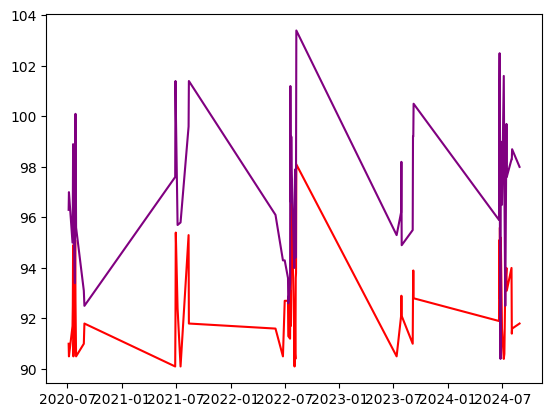

In [ ]:
plt.plot(heat_wave_dataframe['date'], heat_wave_dataframe['temp_max'], color = 'red')
plt.plot(heat_wave_dataframe['date'], heat_wave_dataframe['apparent_temp_max'], color = 'purple')

In [ ]:
heat_wave_dataframe['is_consecutive'] = heat_wave_dataframe['date'].diff().dt.days == 1
heat_wave_dataframe['group'] = (heat_wave_dataframe['is_consecutive'] != 1).cumsum()
heat_wave_dataframe['heat_wave'] = heat_wave_dataframe.groupby('group')['group'].transform('sum')
heat_wave_dataframe = heat_wave_dataframe[heat_wave_dataframe['heat_wave'] >= 3]
heat_wave_dataframe.head(20)

,date,temp_max,apparent_temp_max,is_consecutive,group,heat_wave
199,2020-07-18,91.7,95.0,False,2,8
200,2020-07-19,92.5,96.3,True,2,8
201,2020-07-20,94.9,98.9,True,2,8
202,2020-07-21,90.5,96.6,True,2,8
207,2020-07-26,92.8,93.4,False,3,9
208,2020-07-27,95.1,98.3,True,3,9
209,2020-07-28,92.7,100.1,True,3,9
211,2020-07-30,90.5,95.6,False,4,4
237,2020-08-25,91.0,93.1,False,5,5
239,2020-08-27,91.8,92.5,False,6,6


In [ ]:
consecutive_heat_wave_dates = pd.Series(pd.to_datetime(consecutive_days).unique())
consecutive_heat_wave_dates
heat_wave_summary = consecutive_heat_wave_dates.dt.year.value_counts().sort_index()

print(heat_wave_summary)

2020     3
2022    12
2023     3
2024     3
Name: count, dtype: int64


In [ ]:
# there are no qualifying excessive heat events
excessive_heat_dates = nyc_hourly_temperatures[nyc_hourly_temperatures['apparent_temperature'] >= 105]['']
excessive_heat_dates.head()

KeyError: ''

In [ ]:
top_10_apparent_temp_max = nyc_hourly_temperatures.nlargest(10, 'apparent_temperature')
top_10_apparent_temp_max

,date,temperature,apparent_temperature,precipitation,rain,cloudcover,windspeed
22838,2022-08-09 14:00:00,98.1,103.4,0.0,0.0,100.0,16.7
39228,2024-06-22 12:00:00,92.8,102.5,0.0,0.0,45.0,6.0
22837,2022-08-09 13:00:00,96.1,101.6,0.0,0.0,95.0,17.7
39564,2024-07-06 12:00:00,90.3,101.6,0.0,0.0,21.0,9.1
13092,2021-06-29 12:00:00,91.5,101.4,0.0,0.0,24.0,13.0
14172,2021-08-13 12:00:00,91.0,101.4,0.0,0.0,4.0,5.8
14508,2021-08-27 12:00:00,89.1,101.2,0.0,0.0,18.0,0.0
22357,2022-07-20 13:00:00,93.1,101.2,0.0,0.0,8.0,7.4
14173,2021-08-13 13:00:00,91.8,100.9,0.0,0.0,12.0,10.5
39204,2024-06-21 12:00:00,94.2,100.7,0.0,0.0,46.0,10.7


In [ ]:
from sklearn.linear_model import LinearRegression
hourly_ridership = august_9_sampled.groupby(['timestamp']).size().reset_index(name='hourly_ridership')
hourly_data = pd.merge(hourly_ridership, nyc_hourly_temperatures, left_on='timestamp', right_on='time')

In [ ]:
hourly_ridership.head()

,timestamp,hourly_ridership
0,2022-08-09T00:00:00.000,22319
1,2022-08-09T01:00:00.000,12409
2,2022-08-09T02:00:00.000,9052
3,2022-08-09T03:00:00.000,9897
4,2022-08-09T04:00:00.000,20688


In [ ]:
nyc_hourly_temperatures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42504 entries, 0 to 42503
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   time                       42504 non-null  object 
 1   temperature_2m (°F)        42476 non-null  float64
 2   apparent_temperature (°F)  42476 non-null  float64
 3   precipitation (mm)         42476 non-null  float64
 4   rain (mm)                  42476 non-null  float64
 5   cloud_cover (%)            42476 non-null  float64
 6   wind_speed_10m (km/h)      42476 non-null  float64
dtypes: float64(6), object(1)
memory usage: 2.3+ MB


# August 2022 O/D Data for Heat Waves

In [15]:
# Sample august_8 proportionally based on 'hour_of_day'
august_9_sampled, _ = train_test_split(august_9, test_size=(1 - len(august_11)/len(august_9)), stratify=august_9['timestamp'], random_state=42)

# Use the entire august_9
august_11_sampled = august_11

print(len(august_9_sampled), len(august_11_sampled))  # Should both be equal

1373576 1373577


In [16]:
august_9_sampled.head()

,year,month,day_of_week,hour_of_day,timestamp,origin_station_complex_id,origin_station_complex_name,origin_latitude,origin_longitude,destination_station_complex_id,destination_station_complex_name,destination_latitude,destination_longitude,estimated_average_ridership,origin_point,destination_point
1359048,2022,8,Tuesday,21,2022-08-09T21:00:00.000,94,Halsey St (J),40.686370,-73.916559,393,116 St (6),40.798629,-73.941617,0.2838,"{'type': 'Point', 'coordinates': [-73.916559, ...","{'type': 'Point', 'coordinates': [-73.941617, ..."
201131,2022,8,Tuesday,7,2022-08-09T07:00:00.000,157,"96 St (C,B)",40.791642,-73.964696,100,"Hewes St (M,J)",40.706870,-73.953431,0.2394,"{'type': 'Point', 'coordinates': [-73.964696, ...","{'type': 'Point', 'coordinates': [-73.953431, ..."
183178,2022,8,Tuesday,6,2022-08-09T06:00:00.000,188,"Euclid Av (A,C)",40.675377,-73.872106,307,116 St-Columbia University (1),40.807722,-73.964110,1.6562,"{'type': 'Point', 'coordinates': [-73.872106, ...","{'type': 'Point', 'coordinates': [-73.96411, 4..."
1243541,2022,8,Tuesday,20,2022-08-09T20:00:00.000,153,"125 St (A,C,B,D)",40.811109,-73.952343,150,155 St (C),40.830518,-73.941514,3.7602,"{'type': 'Point', 'coordinates': [-73.952343, ...","{'type': 'Point', 'coordinates': [-73.941514, ..."
912585,2022,8,Tuesday,16,2022-08-09T16:00:00.000,614,"59 St-Columbus Circle (A,B,C,D,1)",40.768272,-73.981833,59,9 Av (D),40.646292,-73.994324,5.9412,"{'type': 'Point', 'coordinates': [-73.981833, ...","{'type': 'Point', 'coordinates': [-73.994324, ..."


In [17]:
# Sample august_8 proportionally based on 'hour_of_day'
august_8_sampled, _ = train_test_split(august_8, test_size=(1 - len(august_11)/len(august_8)), stratify=august_8['timestamp'], random_state=42)


print(len(august_8_sampled), len(august_9_sampled))  # Should both be equal

1373576 1373576


In [18]:
# grab every 100th row of august_8_sampled

august_8_small = august_8_sampled.iloc[::100, :]
august_8_small.to_csv('august_8_small.csv', index=False)

august_9_small = august_9_sampled.iloc[::100, :]
august_9_small.to_csv('august_9_small.csv', index=False)

august_11_small = august_11_sampled.iloc[::100, :]
august_11_small.to_csv('august_11_small.csv', index=False)

## Destination counts and visualization

In [19]:
aug_8_dest_counts = august_8_sampled['destination_station_complex_name'].value_counts()
aug_9_dest_counts = august_9_sampled['destination_station_complex_name'].value_counts()
aug_11_dest_counts = august_11_sampled['destination_station_complex_name'].value_counts()

In [37]:
aug_8_dest_counts.head(10)

,count
destination_station_complex_name,
"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",8520
"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",7577
"Fulton St (A,C,J,Z,2,3,4,5)",7526
"14 St-Union Sq (L,N,Q,R,W,4,5,6)",7524
"Grand Central-42 St (S,4,5,6,7)",7511
"59 St-Columbus Circle (A,B,C,D,1)",7150
"34 St-Penn Station (A,C,E)",7118
"Chambers St (A,C)/WTC (E)/Park Pl (2,3)/Cortlandt (R,W)",6719
"Bryant Pk (B,D,F,M)/5 Av (7)",6568


In [38]:
aug_9_dest_counts.head(10)

,count
destination_station_complex_name,
"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",8356
"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",7413
"Fulton St (A,C,J,Z,2,3,4,5)",7407
"Grand Central-42 St (S,4,5,6,7)",7392
"14 St-Union Sq (L,N,Q,R,W,4,5,6)",7345
"34 St-Penn Station (A,C,E)",6997
"59 St-Columbus Circle (A,B,C,D,1)",6990
"Chambers St (A,C)/WTC (E)/Park Pl (2,3)/Cortlandt (R,W)",6641
"14 St (A,C,E)/8 Av (L)",6485


In [39]:
aug_9_dest_counts.head(11)

,count
destination_station_complex_name,
"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",8356
"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",7413
"Fulton St (A,C,J,Z,2,3,4,5)",7407
"Grand Central-42 St (S,4,5,6,7)",7392
"14 St-Union Sq (L,N,Q,R,W,4,5,6)",7345
"34 St-Penn Station (A,C,E)",6997
"59 St-Columbus Circle (A,B,C,D,1)",6990
"Chambers St (A,C)/WTC (E)/Park Pl (2,3)/Cortlandt (R,W)",6641
"14 St (A,C,E)/8 Av (L)",6485


In [40]:
aug_8_orig_counts = august_8_sampled['origin_station_complex_name'].value_counts()
aug_9_orig_counts = august_9_sampled['origin_station_complex_name'].value_counts()
aug_11_orig_counts = august_11_sampled['origin_station_complex_name'].value_counts()

In [44]:
aug_8_orig_counts.head(10)

,count
origin_station_complex_name,
"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",8998
"Fulton St (A,C,J,Z,2,3,4,5)",7806
"14 St-Union Sq (L,N,Q,R,W,4,5,6)",7774
"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",7720
"Grand Central-42 St (S,4,5,6,7)",7668
"34 St-Penn Station (A,C,E)",7274
"59 St-Columbus Circle (A,B,C,D,1)",7211
"74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,M,R)",6922
"14 St (A,C,E)/8 Av (L)",6776


### Times Square Analysis

In [21]:
aug_8_ts = august_8_sampled[august_8_sampled['origin_station_complex_name'].str.contains('Times Sq')]
aug_9_ts = august_9_sampled[august_9_sampled['origin_station_complex_name'].str.contains('Times Sq')]
aug_11_ts = august_11_sampled[august_11_sampled['origin_station_complex_name'].str.contains('Times Sq')]

In [22]:
import matplotlib.pyplot as plt

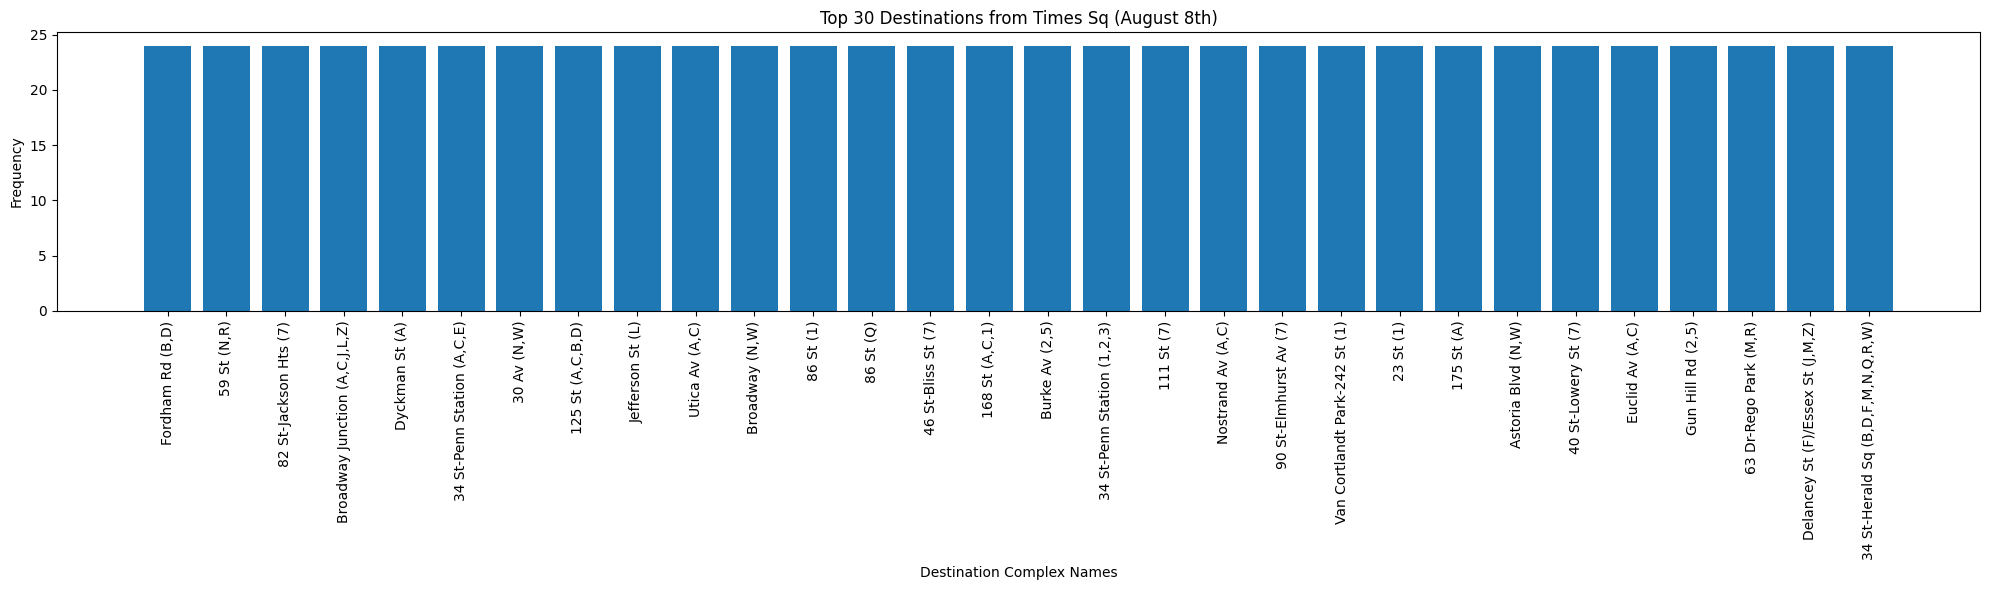

In [23]:
import matplotlib.pyplot as plt

top_30_destinations_aug8 = aug_8_ts['destination_station_complex_name'].value_counts().nlargest(30)

plt.figure(figsize=(20, 6))  # Adjust figure size for better label visibility
plt.bar(top_30_destinations_aug8.index, top_30_destinations_aug8.values)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.xlabel("Destination Complex Names")
plt.ylabel("Frequency")
plt.title("Top 30 Destinations from Times Sq (August 8th)")
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

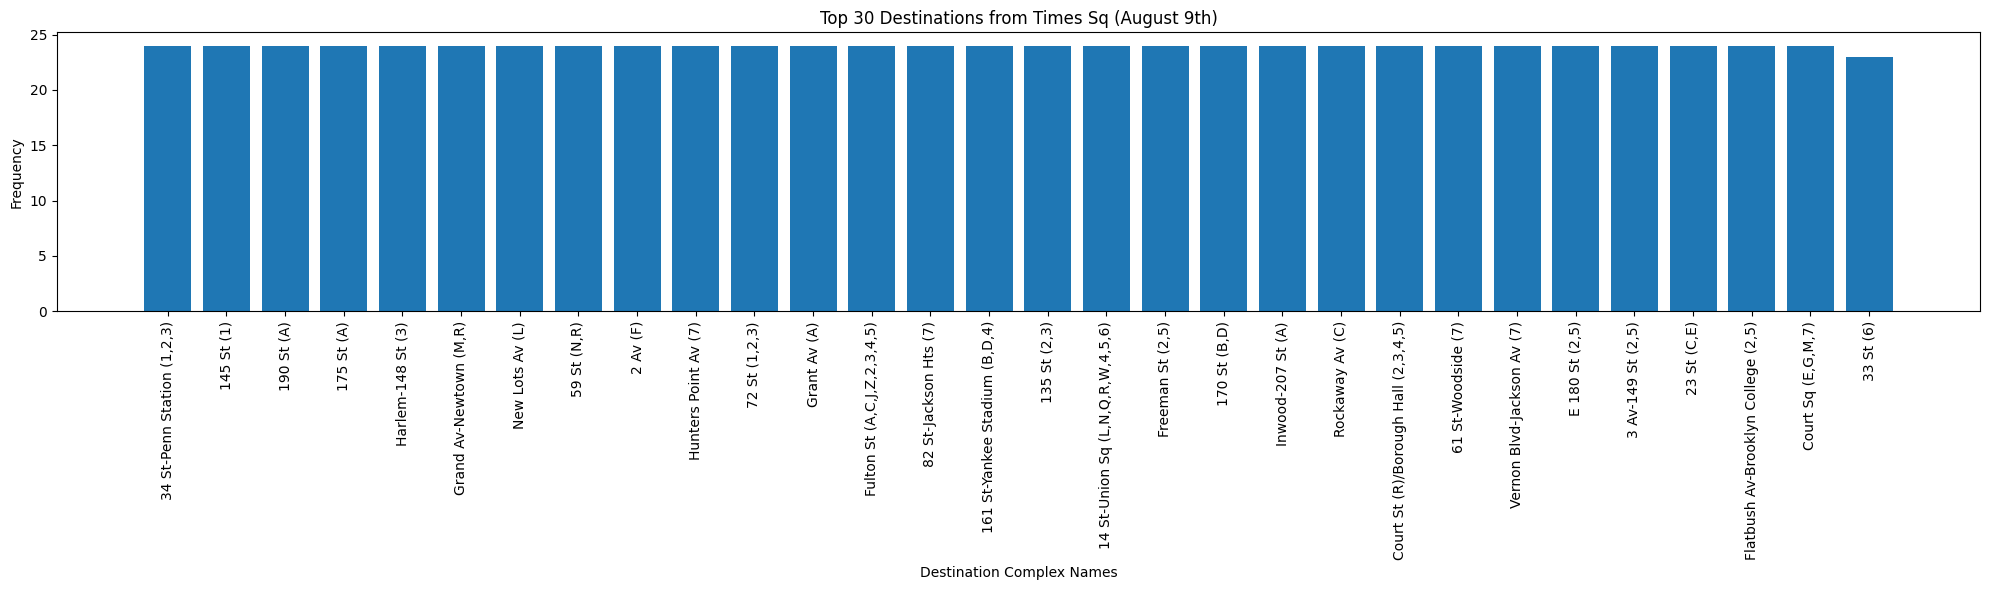

In [24]:
top_30_destinations_aug9 = aug_9_ts['destination_station_complex_name'].value_counts().nlargest(30)

plt.figure(figsize=(20, 6))  # Adjust figure size for better label visibility
plt.bar(top_30_destinations_aug9.index, top_30_destinations_aug9.values)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.xlabel("Destination Complex Names")
plt.ylabel("Frequency")
plt.title("Top 30 Destinations from Times Sq (August 9th)")
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

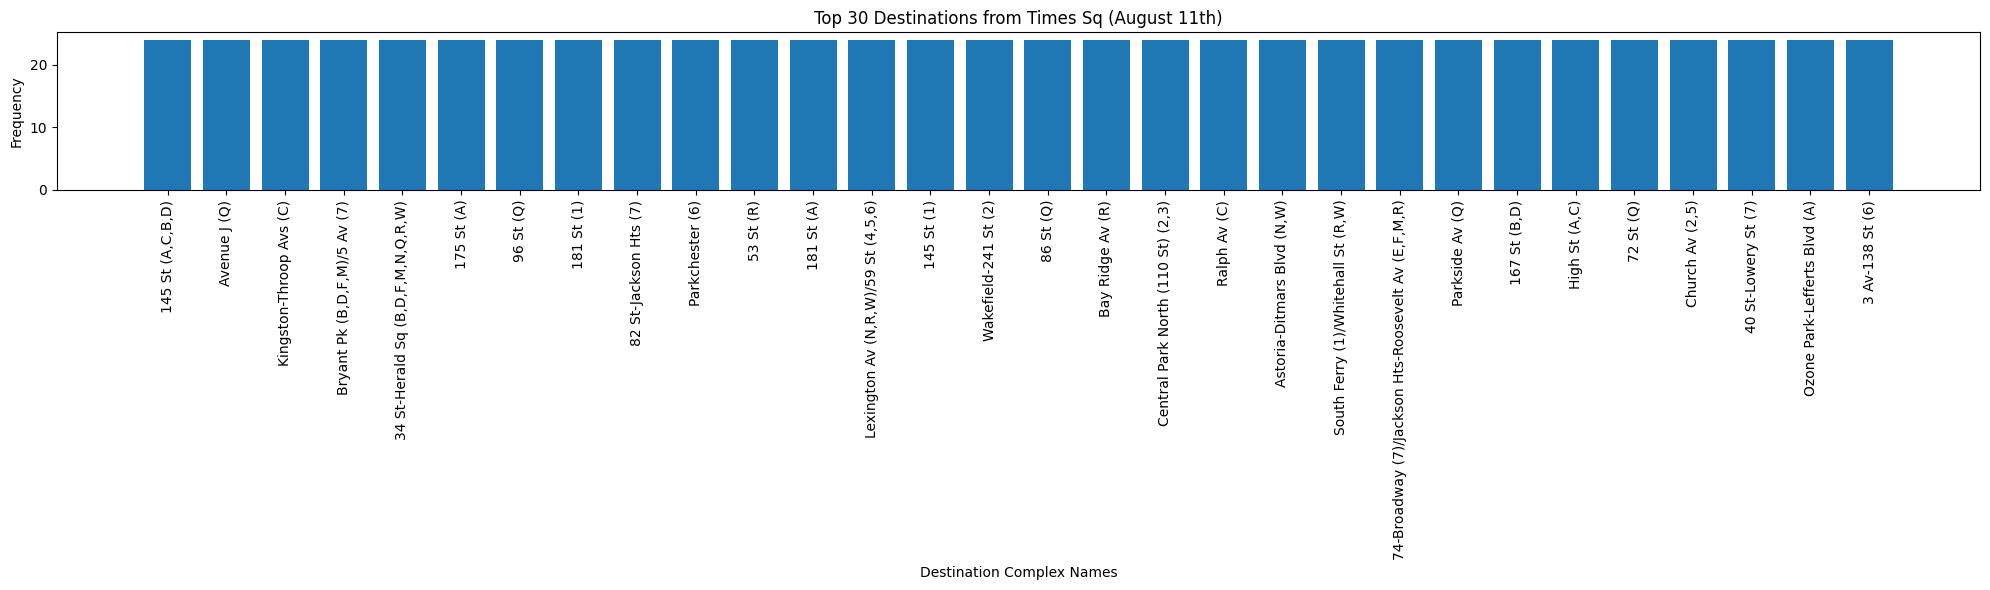

In [25]:
top_30_destinations_aug11 = aug_11_ts['destination_station_complex_name'].value_counts().nlargest(30)

plt.figure(figsize=(20, 6))  # Adjust figure size for better label visibility
plt.bar(top_30_destinations_aug11.index, top_30_destinations_aug11.values)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.xlabel("Destination Complex Names")
plt.ylabel("Frequency")
plt.title("Top 30 Destinations from Times Sq (August 11th)")
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [26]:
aug_9_dest_counts[10]

<ipython-input-26-65e8b1ae7696>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aug_9_dest_counts[10]


6456

In [27]:
aug_11_dest_counts

,count
destination_station_complex_name,
"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",8737
"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",7758
"Fulton St (A,C,J,Z,2,3,4,5)",7744
"Grand Central-42 St (S,4,5,6,7)",7727
"14 St-Union Sq (L,N,Q,R,W,4,5,6)",7710
...,...
Aqueduct-N Conduit Av (A),751
"Beach 98 St (A,S)",665
Beach 44 St (A),613


## T-Test to compare ridership

In [28]:
august_8_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1373576 entries, 492244 to 463560
Data columns (total 16 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   year                              1373576 non-null  int64  
 1   month                             1373576 non-null  int64  
 2   day_of_week                       1373576 non-null  object 
 3   hour_of_day                       1373576 non-null  int64  
 4   timestamp                         1373576 non-null  object 
 5   origin_station_complex_id         1373576 non-null  int64  
 6   origin_station_complex_name       1373576 non-null  object 
 7   origin_latitude                   1373576 non-null  float64
 8   origin_longitude                  1373576 non-null  float64
 9   destination_station_complex_id    1373576 non-null  int64  
 10  destination_station_complex_name  1373576 non-null  object 
 11  destination_latitude              1373

In [29]:
# Combine control data
august_heatwave_dates = august_8_sampled
august_control_dates = pd.concat([august_9_sampled, august_11_sampled])

# Perform the t-test
t_stat, p_value = ttest_ind(
    august_heatwave_dates['estimated_average_ridership'],
    august_control_dates['estimated_average_ridership'],
    equal_var=False  # Welch's t-test (handles unequal variances)
)

# Print results
print("Two-Sample T-Test Results:")
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

# Interpret the p-value
if p_value < 0.05:
    print("The difference in ridership between heat wave and control days is statistically significant.")
else:
    print("No statistically significant difference in ridership between heat wave and control days.")

Two-Sample T-Test Results:
T-Statistic: -36.10899477479009
P-Value: 1.8789321930224285e-285
The difference in ridership between heat wave and control days is statistically significant.


In [30]:
# Descriptive statistics
print("Heatwave Days Statistics:")
print(august_heatwave_dates['estimated_average_ridership'].describe())

print("\nControl Days Statistics:")
print(august_control_dates['estimated_average_ridership'].describe())

Heatwave Days Statistics:
count    1.373576e+06
mean     1.952996e+00
std      5.992480e+00
min      1.500000e-01
25%      2.606000e-01
50%      6.000000e-01
75%      1.579800e+00
max      7.038986e+02
Name: estimated_average_ridership, dtype: float64

Control Days Statistics:
count    2.747153e+06
mean     2.190961e+00
std      6.891330e+00
min      1.000000e-01
25%      3.115000e-01
50%      6.876000e-01
75%      1.765500e+00
max      9.947674e+02
Name: estimated_average_ridership, dtype: float64


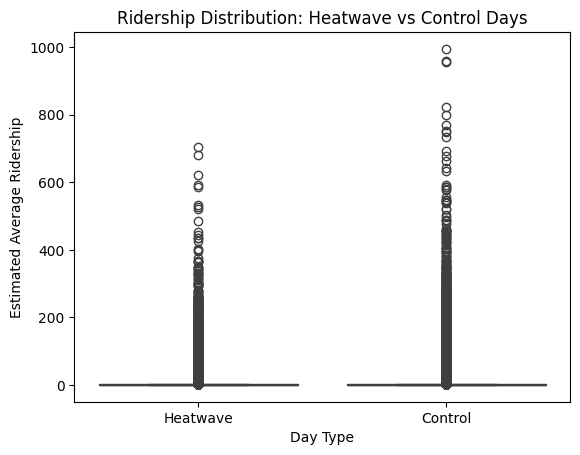

In [31]:
import seaborn as sns
# Combine data for visualization
august_heatwave_dates['Label'] = 'Heatwave'
august_control_dates['Label'] = 'Control'
combined_data = pd.concat([august_heatwave_dates, august_control_dates])

# Box plot
sns.boxplot(data=combined_data, x='Label', y='estimated_average_ridership')
plt.title('Ridership Distribution: Heatwave vs Control Days')
plt.xlabel('Day Type')
plt.ylabel('Estimated Average Ridership')
plt.show()

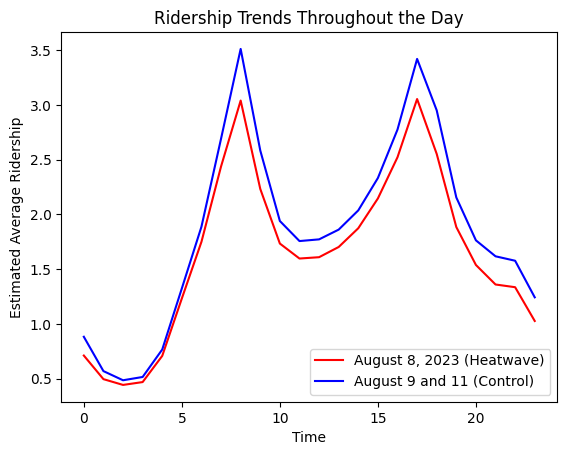

In [32]:
# Example: Group by time and calculate the mean ridership
heatwave_trend = august_heatwave_dates.groupby('hour_of_day')['estimated_average_ridership'].mean()
control_trend = august_control_dates.groupby('hour_of_day')['estimated_average_ridership'].mean()

plt.plot(heatwave_trend.index, heatwave_trend, label='August 8, 2023 (Heatwave)', color='red')
plt.plot(control_trend.index, control_trend, label='August 9 and 11 (Control)', color='blue')
plt.title('Ridership Trends Throughout the Day')
plt.xlabel('Time')
plt.ylabel('Estimated Average Ridership')
plt.legend()
plt.show()

## Beach analysis

In [33]:
# Define the list of Beach MTA Stations
beach_stations = ['Aquarium', 'Coney Island', 'Neptune', 'Bay 50 St', 'Ocean Pkwy', 'Beach']

# Filter the dataframe for rows where 'destination_station_complex_name' contains any of the strings in beach_stations
aug22_heatwave_beaches = august_8_sampled[
    august_8_sampled['destination_station_complex_name'].str.contains('|'.join(beach_stations), case=False, na=False)
]

# Display the filtered dataframe
aug22_heatwave_beaches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26251 entries, 407909 to 472402
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   year                              26251 non-null  int64  
 1   month                             26251 non-null  int64  
 2   day_of_week                       26251 non-null  object 
 3   hour_of_day                       26251 non-null  int64  
 4   timestamp                         26251 non-null  object 
 5   origin_station_complex_id         26251 non-null  int64  
 6   origin_station_complex_name       26251 non-null  object 
 7   origin_latitude                   26251 non-null  float64
 8   origin_longitude                  26251 non-null  float64
 9   destination_station_complex_id    26251 non-null  int64  
 10  destination_station_complex_name  26251 non-null  object 
 11  destination_latitude              26251 non-null  float64
 12  des

In [34]:
# Filter the heatwave and control datasets for beach stations
august_8_beaches = august_8_sampled[
    august_8_sampled['destination_station_complex_name'].str.contains('|'.join(beach_stations), case=False, na=False)
]

august_control_beaches = august_control_dates[
    august_control_dates['destination_station_complex_name'].str.contains('|'.join(beach_stations), case=False, na=False)
]

# Perform the t-test
t_stat, p_value = ttest_ind(
    august_8_beaches['estimated_average_ridership'],
    august_control_beaches['estimated_average_ridership'],
    equal_var=False  # Welch's t-test (handles unequal variances)
)

# Print results
print("Two-Sample T-Test Results for Beach Stations:")
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("The difference in ridership between heat wave and control days for beach stations is statistically significant.")
else:
    print("No statistically significant difference in ridership between heat wave and control days for beach stations.")

Two-Sample T-Test Results for Beach Stations:
T-Statistic: -6.528026085729555
P-Value: 6.720432912099072e-11
The difference in ridership between heat wave and control days for beach stations is statistically significant.


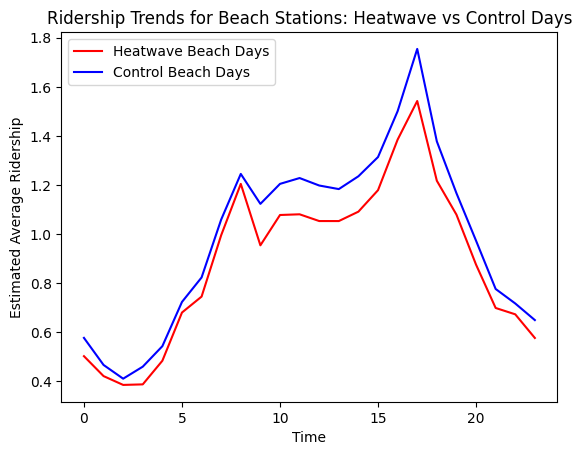

In [35]:
# Ridership trends over time
august_8_beaches_trend = august_8_beaches.groupby('hour_of_day')['estimated_average_ridership'].mean()
august_control_beaches_trend = august_control_beaches.groupby('hour_of_day')['estimated_average_ridership'].mean()

# Plot ridership trends
plt.plot(august_8_beaches_trend.index, august_8_beaches_trend, label='Heatwave Beach Days', color='red')
plt.plot(august_control_beaches_trend.index, august_control_beaches_trend, label='Control Beach Days', color='blue')
plt.title('Ridership Trends for Beach Stations: Heatwave vs Control Days')
plt.xlabel('Time')
plt.ylabel('Estimated Average Ridership')
plt.legend()
plt.show()

# Extracting HVI/Income Clusters by Station in Sampled Data

## Loading and Grouping HVI/Income Data



In [46]:
NYC_HVI = pd.read_csv('/content/drive/MyDrive/INFO5430 Urban Data Final Project/Data/Heat_Vulnerability_Index_Rankings.csv')

In [47]:
ZCTA_Income = pd.read_csv('/content/drive/MyDrive/INFO5430 Urban Data Final Project/Data/median household income by ZCTA.csv')

In [48]:
NYC_HVI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 2 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   ZIP Code Tabulation Area (ZCTA) 2020  184 non-null    int64
 1   Heat Vulnerability Index (HVI)        184 non-null    int64
dtypes: int64(2)
memory usage: 3.0 KB


In [49]:
ZCTA_Income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33774 entries, 0 to 33773
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SE_A14006_001  30621 non-null  float64
 1   Geo_ZCTA5      33774 non-null  int64  
 2   Geo_FIPS       33774 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 791.7 KB


In [50]:
HVI_ZCTA_Merged = pd.merge(NYC_HVI, ZCTA_Income, left_on='ZIP Code Tabulation Area (ZCTA) 2020', right_on='Geo_ZCTA5', how='left')
HVI_ZCTA_Merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ZIP Code Tabulation Area (ZCTA) 2020  184 non-null    int64  
 1   Heat Vulnerability Index (HVI)        184 non-null    int64  
 2   SE_A14006_001                         180 non-null    float64
 3   Geo_ZCTA5                             184 non-null    int64  
 4   Geo_FIPS                              184 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 7.3 KB


In [51]:
# Drop rows with empty values in HVI to filter for NYC
HVI_ZCTA_Merged = HVI_ZCTA_Merged.dropna(subset=['Heat Vulnerability Index (HVI)'])

In [52]:
HVI_ZCTA_Merged.head()

,ZIP Code Tabulation Area (ZCTA) 2020,Heat Vulnerability Index (HVI),SE_A14006_001,Geo_ZCTA5,Geo_FIPS
0,10465,1,85946.0,10465,10465
1,10310,3,105523.0,10310,10310
2,11203,5,68006.0,11203,11203
3,11224,5,40467.0,11224,11224
4,11212,5,35840.0,11212,11212


In [53]:
# Rename ACS column
HVI_ZCTA_Merged = HVI_ZCTA_Merged.rename(columns={'SE_A14006_001': 'Median Household Income (In 2022 Inflation Adjusted Dollars)'})

print(HVI_ZCTA_Merged.columns) # Verify the column name change

Index(['ZIP Code Tabulation Area (ZCTA) 2020',
       'Heat Vulnerability Index (HVI)',
       'Median Household Income (In 2022 Inflation Adjusted Dollars)',
       'Geo_ZCTA5', 'Geo_FIPS'],
      dtype='object')


In [54]:
# Convert 'Median Household Income' to numeric, coercing errors to NaN
HVI_ZCTA_Merged['Median Household Income (In 2022 Inflation Adjusted Dollars)'] = pd.to_numeric(HVI_ZCTA_Merged['Median Household Income (In 2022 Inflation Adjusted Dollars)'], errors='coerce')

# Format the 'Median Household Income' column as USD currency
HVI_ZCTA_Merged['Median Household Income (In 2022 Inflation Adjusted Dollars)'] = HVI_ZCTA_Merged['Median Household Income (In 2022 Inflation Adjusted Dollars)'].apply(lambda x: "${:,.2f}".format(x) if pd.notna(x) else "")

In [55]:
HVI_ZCTA_Merged.head()

,ZIP Code Tabulation Area (ZCTA) 2020,Heat Vulnerability Index (HVI),Median Household Income (In 2022 Inflation Adjusted Dollars),Geo_ZCTA5,Geo_FIPS
0,10465,1,"$85,946.00",10465,10465
1,10310,3,"$105,523.00",10310,10310
2,11203,5,"$68,006.00",11203,11203
3,11224,5,"$40,467.00",11224,11224
4,11212,5,"$35,840.00",11212,11212


In [56]:
# Cleaned and merged data
NYC_HVI_Income_ZCTAs = HVI_ZCTA_Merged

In [57]:
NYC_HVI_Income_ZCTAs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 5 columns):
 #   Column                                                        Non-Null Count  Dtype 
---  ------                                                        --------------  ----- 
 0   ZIP Code Tabulation Area (ZCTA) 2020                          184 non-null    int64 
 1   Heat Vulnerability Index (HVI)                                184 non-null    int64 
 2   Median Household Income (In 2022 Inflation Adjusted Dollars)  184 non-null    object
 3   Geo_ZCTA5                                                     184 non-null    int64 
 4   Geo_FIPS                                                      184 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.3+ KB


In [58]:
# High and Low HVI Groups
high_HVI = NYC_HVI_Income_ZCTAs[NYC_HVI_Income_ZCTAs['Heat Vulnerability Index (HVI)'] > 4]

low_HVI = NYC_HVI_Income_ZCTAs[NYC_HVI_Income_ZCTAs['Heat Vulnerability Index (HVI)'] <= 2]

In [59]:
# high_HVI.head()

In [60]:
# Threshold to determine high and low income using quintiles
NYC_HVI_Income_ZCTAs['Median Household Income (In 2022 Inflation Adjusted Dollars)'] = NYC_HVI_Income_ZCTAs['Median Household Income (In 2022 Inflation Adjusted Dollars)'].astype(str).str.replace(r'[$,]', '', regex=True).replace('', np.nan, regex=True).astype(float)

# Calculate quintiles
quintiles = NYC_HVI_Income_ZCTAs['Median Household Income (In 2022 Inflation Adjusted Dollars)'].quantile([0.2, 0.4, 0.6, 0.8])

quintiles

,Median Household Income (In 2022 Inflation Adjusted Dollars)
0.2,59145.4
0.4,77443.6
0.6,91901.0
0.8,121136.6


In [61]:
# Define income thresholds based on top 20 and bottom 20 quintiles from above
low_income_threshold = 59145.4
high_income_threshold = 121136.6

bottom20income = NYC_HVI_Income_ZCTAs[NYC_HVI_Income_ZCTAs['Median Household Income (In 2022 Inflation Adjusted Dollars)'] <= 59145.4]
top20income = NYC_HVI_Income_ZCTAs[NYC_HVI_Income_ZCTAs['Median Household Income (In 2022 Inflation Adjusted Dollars)'] <= 121136.6]

## HVI and Income Correlation and Regression

OLS Summary:
                                  OLS Regression Results                                  
Dep. Variable:     Heat Vulnerability Index (HVI)   R-squared:                       0.490
Model:                                        OLS   Adj. R-squared:                  0.487
Method:                             Least Squares   F-statistic:                     170.9
Date:                            Fri, 06 Dec 2024   Prob (F-statistic):           8.29e-28
Time:                                    22:13:58   Log-Likelihood:                -257.44
No. Observations:                             180   AIC:                             518.9
Df Residuals:                                 178   BIC:                             525.3
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
                                                                   coef    st

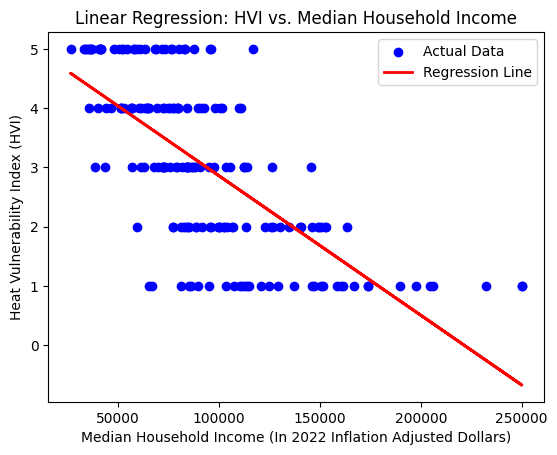

R-squared: 0.48978589342950274


In [ ]:
import statsmodels.api as sm

NYC_HVI_Income_ZCTAs_cleaned = NYC_HVI_Income_ZCTAs.dropna(
    subset=['Heat Vulnerability Index (HVI)', 'Median Household Income (In 2022 Inflation Adjusted Dollars)']
)

# Define the independent and dependent variables
X = NYC_HVI_Income_ZCTAs_cleaned[['Median Household Income (In 2022 Inflation Adjusted Dollars)']]
y = NYC_HVI_Income_ZCTAs_cleaned['Heat Vulnerability Index (HVI)']

# Add a constant for the intercept term for statsmodels
X_with_const = sm.add_constant(X)

# Fit the model using statsmodels for detailed statistics
ols_model = sm.OLS(y, X_with_const).fit()

# Print the confidence intervals, p-values, and other statistics
print("OLS Summary:")
print(ols_model.summary())

# Create and fit the linear regression model using sklearn
model = LinearRegression()
model.fit(X, y)

# Print the model coefficients
print("Intercept:", model.intercept_)
print("Coefficient:", model.coef_)

# Make predictions
y_pred = model.predict(X)

# Visualize the results
plt.scatter(X, y, color='blue', label='Actual Data')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel('Median Household Income (In 2022 Inflation Adjusted Dollars)')
plt.ylabel('Heat Vulnerability Index (HVI)')
plt.title('Linear Regression: HVI vs. Median Household Income')
plt.legend()
plt.show()

# Calculate R-squared
r_squared = model.score(X, y)
print(f"R-squared: {r_squared}")

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

# Calculate confidence intervals and p-values
confidence_interval_income = stats.t.interval(0.95, len(NYC_HVI_Income_ZCTAs_cleaned['Median Household Income (In 2022 Inflation Adjusted Dollars)']) - 1,
                                               loc=np.mean(NYC_HVI_Income_ZCTAs_cleaned['Median Household Income (In 2022 Inflation Adjusted Dollars)']),
                                               scale=stats.sem(NYC_HVI_Income_ZCTAs_cleaned['Median Household Income (In 2022 Inflation Adjusted Dollars)']))
p_value_income = stats.ttest_1samp(NYC_HVI_Income_ZCTAs_cleaned['Median Household Income (In 2022 Inflation Adjusted Dollars)'], popmean=0).pvalue


confidence_interval_hvi = stats.t.interval(0.95, len(NYC_HVI_Income_ZCTAs_cleaned['Heat Vulnerability Index (HVI)']) - 1,
                                           loc=np.mean(NYC_HVI_Income_ZCTAs_cleaned['Heat Vulnerability Index (HVI)']),
                                           scale=stats.sem(NYC_HVI_Income_ZCTAs_cleaned['Heat Vulnerability Index (HVI)']))
p_value_hvi = stats.ttest_1samp(NYC_HVI_Income_ZCTAs_cleaned['Heat Vulnerability Index (HVI)'], popmean=0).pvalue

print("Median Household Income:")
print(f"95% Confidence Interval: {confidence_interval_income}")
print(f"P-value: {p_value_income}")

print("\nHeat Vulnerability Index:")
print(f"95% Confidence Interval: {confidence_interval_hvi}")
print(f"P-value: {p_value_hvi}")

Median Household Income:
95% Confidence Interval: (86551.59987917983, 98977.35567637572)
P-value: 1.434757582849267e-70

Heat Vulnerability Index:
95% Confidence Interval: (2.8189435961432876, 3.2366119594122678)
P-value: 1.1063349620779655e-68


In [ ]:
correlation = NYC_HVI_Income_ZCTAs['Heat Vulnerability Index (HVI)'].corr(NYC_HVI_Income_ZCTAs['Median Household Income (In 2022 Inflation Adjusted Dollars)'])

print(f"Correlation between HVI and Median Household Income: {correlation}")

Correlation between HVI and Median Household Income: -0.6998470500255775


## Filtering for High/Low HVI/Income Stations

In [62]:
high_HVI['Median Household Income (In 2022 Inflation Adjusted Dollars)'] = pd.to_numeric(
    high_HVI['Median Household Income (In 2022 Inflation Adjusted Dollars)'],
    errors='coerce'
)

low_HVI['Median Household Income (In 2022 Inflation Adjusted Dollars)'] = pd.to_numeric(
    low_HVI['Median Household Income (In 2022 Inflation Adjusted Dollars)'],
    errors='coerce'
)

<ipython-input-62-29152d958ea1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_HVI['Median Household Income (In 2022 Inflation Adjusted Dollars)'] = pd.to_numeric(
<ipython-input-62-29152d958ea1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_HVI['Median Household Income (In 2022 Inflation Adjusted Dollars)'] = pd.to_numeric(


In [63]:
# High HVI, High Income
high_HVI_high_income = high_HVI[high_HVI['Median Household Income (In 2022 Inflation Adjusted Dollars)'] >= 121136.6]

high_HVI_high_income

,ZIP Code Tabulation Area (ZCTA) 2020,Heat Vulnerability Index (HVI),Median Household Income (In 2022 Inflation Adjusted Dollars),Geo_ZCTA5,Geo_FIPS


There are no High HVI AND High Income stations!

In [ ]:
# High HVI, Moderately Income
high_HVI_high_income = high_HVI[high_HVI['Median Household Income (In 2022 Inflation Adjusted Dollars)'] >= 91901.0]

high_HVI_high_income

,ZIP Code Tabulation Area (ZCTA) 2020,Heat Vulnerability Index (HVI),Median Household Income (In 2022 Inflation Adjusted Dollars),Geo_ZCTA5,Geo_FIPS


Note: High HVI / High Income stations are in Queens Village / Cambria Heights, far from most MTA stops. Closest stop is 179 St (F) but that station is located in a low income neighborhood.

In [64]:
# Moderately High HVI, Moderately High Income
mod_high_HVI_mod_income = NYC_HVI_Income_ZCTAs[
    (NYC_HVI_Income_ZCTAs['Median Household Income (In 2022 Inflation Adjusted Dollars)'] >= 91901.0) &
    (NYC_HVI_Income_ZCTAs['Heat Vulnerability Index (HVI)'] == 4)
]

# Display the filtered data
mod_high_HVI_mod_income

,ZIP Code Tabulation Area (ZCTA) 2020,Heat Vulnerability Index (HVI),Median Household Income (In 2022 Inflation Adjusted Dollars),Geo_ZCTA5,Geo_FIPS
23,11101,4,109625.0,11101,11101
102,11216,4,92684.0,11216,11216
113,11694,4,100190.0,11694,11694
130,11420,4,97919.0,11420,11420
147,11413,4,111065.0,11413,11413
157,11422,4,101416.0,11422,11422


In [ ]:

print(high_HVI_mod_income.nlargest(10, 'Median Household Income (In 2022 Inflation Adjusted Dollars)'))

     ZIP Code Tabulation Area (ZCTA) 2020  Heat Vulnerability Index (HVI)  \
147                                 11413                               4   
23                                  11101                               4   
157                                 11422                               4   
113                                 11694                               4   
130                                 11420                               4   
102                                 11216                               4   

     Median Household Income (In 2022 Inflation Adjusted Dollars)  Geo_ZCTA5  \
147                                           111065.0                 11413   
23                                            109625.0                 11101   
157                                           101416.0                 11422   
113                                           100190.0                 11694   
130                                            97919.0      

Since there were no High HVI/High Income stations, closest thing is HVI = 4 and income in 60th quantile. Stations in ZIP codes include:


*   Long Island City/Queensbridge (Court Sq, 39 Av, 21 St-Queensbridge, Hunters Point Av)
*   Bedford-Stuyvesant (Nostrand Av, Kingston-Throop Avs)
*   Rockaway (Rockaway Park-Beach 116 St, Beach 105 St, Beach 98 St)
*   South Ozone Park (Aqueduct North Conduit Av., Aqueduct Racetrack)

In [ ]:
# High HVI, Low Income
high_HVI_low_income = high_HVI[high_HVI['Median Household Income (In 2022 Inflation Adjusted Dollars)'] <= low_income_threshold]
high_HVI_low_income.nsmallest(10, 'Median Household Income (In 2022 Inflation Adjusted Dollars)')

,ZIP Code Tabulation Area (ZCTA) 2020,Heat Vulnerability Index (HVI),Median Household Income (In 2022 Inflation Adjusted Dollars),Geo_ZCTA5,Geo_FIPS,HVI_Category,Income_Category
9,10454,5,26400.0,10454,10454,High HVI,Low Income
26,10460,5,33080.0,10460,10460,High HVI,Low Income
45,10456,5,33317.0,10456,10456,High HVI,Low Income
29,10451,5,34316.0,10451,10451,High HVI,Low Income
19,10453,5,34800.0,10453,10453,High HVI,Low Income
18,10455,5,35813.0,10455,10455,High HVI,Low Income
4,11212,5,35840.0,11212,11212,High HVI,Low Income
25,10452,5,36536.0,10452,10452,High HVI,Low Income
13,10035,5,36989.0,10035,10035,High HVI,Low Income
3,11224,5,40467.0,11224,11224,High HVI,Low Income


High HVI, Low Income Neighborhoods primarily in West and South Bronx, Brownsville Brooklyn

In [ ]:
# Low HVI, Low Income
low_HVI_low_income = low_HVI[low_HVI['Median Household Income (In 2022 Inflation Adjusted Dollars)'] <= low_income_threshold]
low_HVI_low_income.nsmallest(10, 'Median Household Income (In 2022 Inflation Adjusted Dollars)')

,ZIP Code Tabulation Area (ZCTA) 2020,Heat Vulnerability Index (HVI),Median Household Income (In 2022 Inflation Adjusted Dollars),Geo_ZCTA5,Geo_FIPS,HVI_Category,Income_Category
40,10040,2,59115.0,10040,10040,Medium HVI,Low Income


Only one Low HVI/Low Income ZIP, Washington Heights. 175 St closest station

In [ ]:
# Low HVI, High Income
low_HVI_high_income = low_HVI[low_HVI['Median Household Income (In 2022 Inflation Adjusted Dollars)'] >= high_income_threshold]
low_HVI_high_income.nlargest(10, 'Median Household Income (In 2022 Inflation Adjusted Dollars)')

,ZIP Code Tabulation Area (ZCTA) 2020,Heat Vulnerability Index (HVI),Median Household Income (In 2022 Inflation Adjusted Dollars),Geo_ZCTA5,Geo_FIPS,HVI_Category,Income_Category
22,10007,1,250001.0,10007,10007,Low HVI,High Income
183,10282,1,250001.0,10282,10282,Low HVI,High Income
178,10004,1,232543.0,10004,10004,Low HVI,High Income
180,10280,1,206150.0,10280,10280,Low HVI,High Income
179,10006,1,204574.0,10006,10006,Low HVI,High Income
174,10069,1,197680.0,10069,10069,Low HVI,High Income
181,10005,1,189886.0,10005,10005,Low HVI,High Income
182,11109,1,173939.0,11109,11109,Low HVI,High Income
166,11215,1,173899.0,11215,11215,Low HVI,High Income
170,10024,1,166994.0,10024,10024,Low HVI,High Income


Low HVI High Income neighborhoods include:

*   Lower Manhattan around City Hall (Chambers St, World Trade Center, Cortland  St, Bowling Green, Whitehall St-South Ferry)
*   Park Slope (4 Av-9 St, 7 Av)
*   Upper West Side (86 St, 79 St)

In [ ]:
high_hvi_high_income = ['Court Sq', 'Aqueduct', 'Rockaway Park', 'Beach 105 St', 'Beach 98 St']
high_hvi_low_income = ['Cypress Av (6)', 'Jamaica - 179 St', 'Sutter Av']
low_hvi_high_income = ['86 St', '4 Av - 9 St', 'Chambers St']
low_hvi_low_income = ['175 St']

## HVI/Income Cluster Station Groups Count

In [ ]:
station_groups = {
    'high_hvi_high_income': {
        'stations': ['Court Sq', 'Aqueduct', 'Rockaway Park', 'Beach 105 St', 'Beach 98 St'],
    },
    'high_hvi_low_income': {
        'stations': ['Cypress Av (6)', 'Jamaica - 179 St', 'Sutter Av'],
    },
    'low_hvi_high_income': {
        'stations': ['86 St', '4 Av - 9 St', 'Chambers St'],
    },
    'low_hvi_low_income': {
        'stations': ['175 St'],
        'HVI': 1,
    }
}

In [ ]:
def analyze_station_group(dataframe, stations, group_by_origin=True, limit=20):
    """
    Analyze and group by a list of stations, either as origin or destination.

    Parameters:
    - dataframe: The dataframe containing the station data.
    - stations: A list of substrings to match station names.
    - group_by_origin: If True, group by origin stations; otherwise, group by destination stations.

    Returns:
    - A pandas Series containing counts of stations.
    """
    column_to_filter = 'origin_station_complex_name' if group_by_origin else 'destination_station_complex_name'
    column_to_count = 'destination_station_complex_name' if group_by_origin else 'origin_station_complex_name'

    # Filter the dataframe for the given stations
    filtered_df = dataframe[dataframe[column_to_filter].str.contains('|'.join(stations), case=False, na=False)]

    # Group and count
    counts = filtered_df[column_to_count].value_counts().head(limit)

    return counts

In [ ]:
def plot_stations_counts(counts,date, group_by_origin=True):
    """
    Plot the counts of stations.

    Parameters:
    - counts: A pandas Series containing counts of stations.
    - group_by_origin: If True, plot origin stations; otherwise, plot destination stations.
    # Plot the counts
    """
    counts.plot(kind='bar', figsize=(10, 6))
    plt.title(f"Counts of Stations Grouped by {'Origin' if group_by_origin else 'Destination'} on {date}")
    plt.xlabel('Station')
    plt.ylabel('Counts')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
aug_8_high_hvi_high_income = analyze_station_group(august_8_sampled, high_hvi_high_income, group_by_origin=True, limit=20)
aug_9_high_hvi_highincome =  analyze_station_group(august_9_sampled, high_hvi_high_income, group_by_origin=True, limit=20)
aug_11_high_hvi_highincome =  analyze_station_group(august_11_sampled, high_hvi_high_income, group_by_origin=True, limit=20)

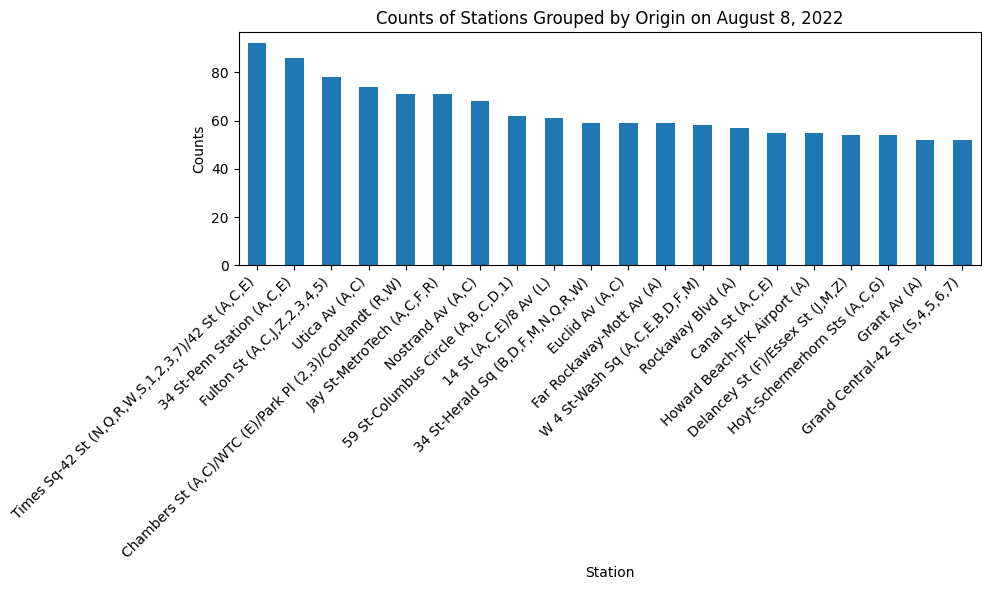

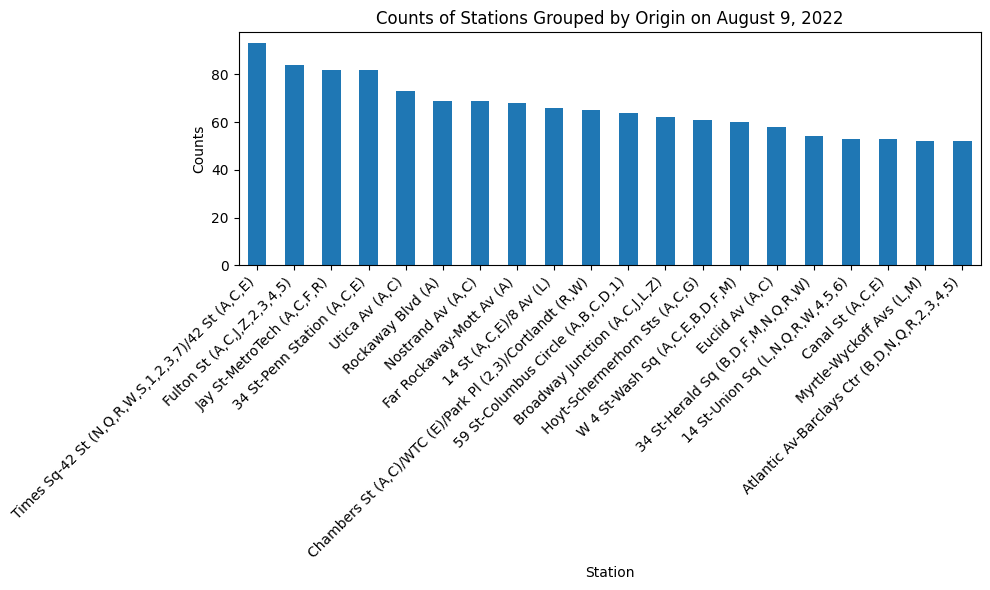

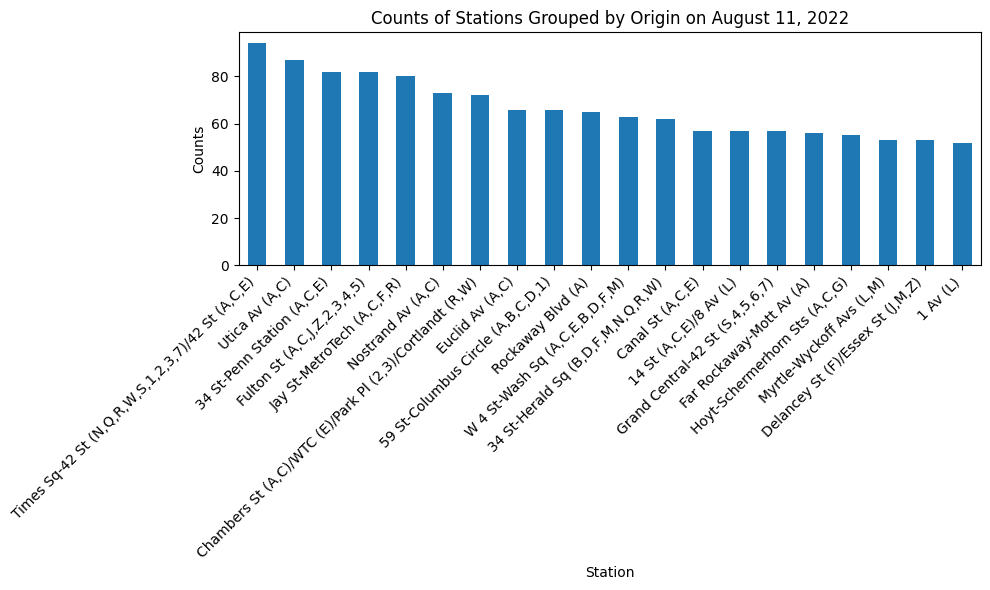

In [ ]:
plot_stations_counts(aug_8_high_hvi_high_income, 'August 8, 2022')
plot_stations_counts(aug_9_high_hvi_highincome, 'August 9, 2022')
plot_stations_counts(aug_11_high_hvi_highincome, 'August 11, 2022')

In [ ]:
aug_8_high_hvi_low_income = analyze_station_group(august_8_sampled, high_hvi_low_income, group_by_origin=True, limit=20)
aug_9_high_hvi_low_income =  analyze_station_group(august_9_sampled, high_hvi_low_income, group_by_origin=True, limit=20)
aug_11_high_hvi_low_income =  analyze_station_group(august_11_sampled, high_hvi_low_income, group_by_origin=True, limit=20)

<ipython-input-89-4553febab390>:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_df = dataframe[dataframe[column_to_filter].str.contains('|'.join(stations), case=False, na=False)]
<ipython-input-89-4553febab390>:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_df = dataframe[dataframe[column_to_filter].str.contains('|'.join(stations), case=False, na=False)]
<ipython-input-89-4553febab390>:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_df = dataframe[dataframe[column_to_filter].str.contains('|'.join(stations), case=False, na=False)]


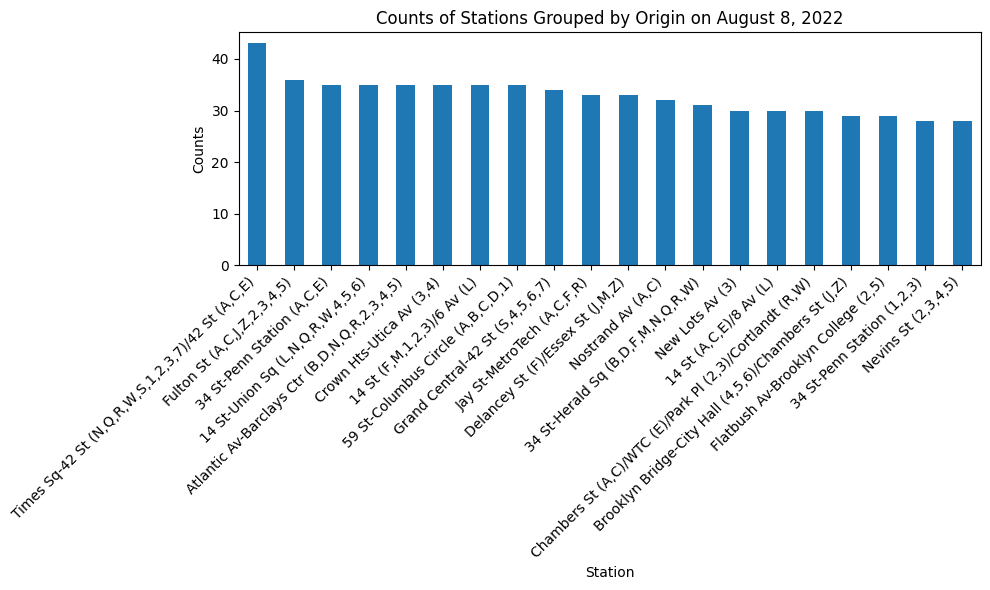

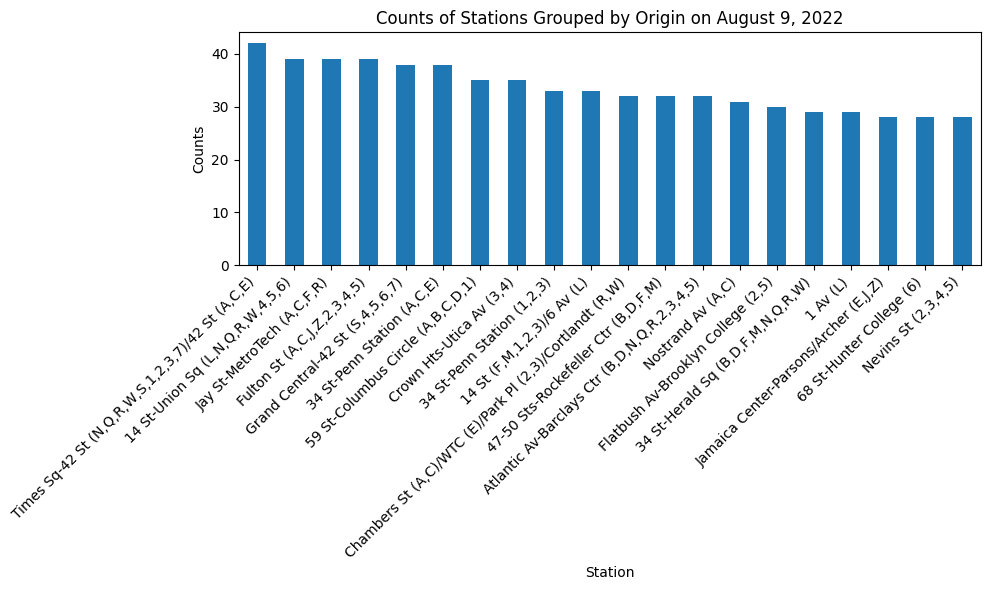

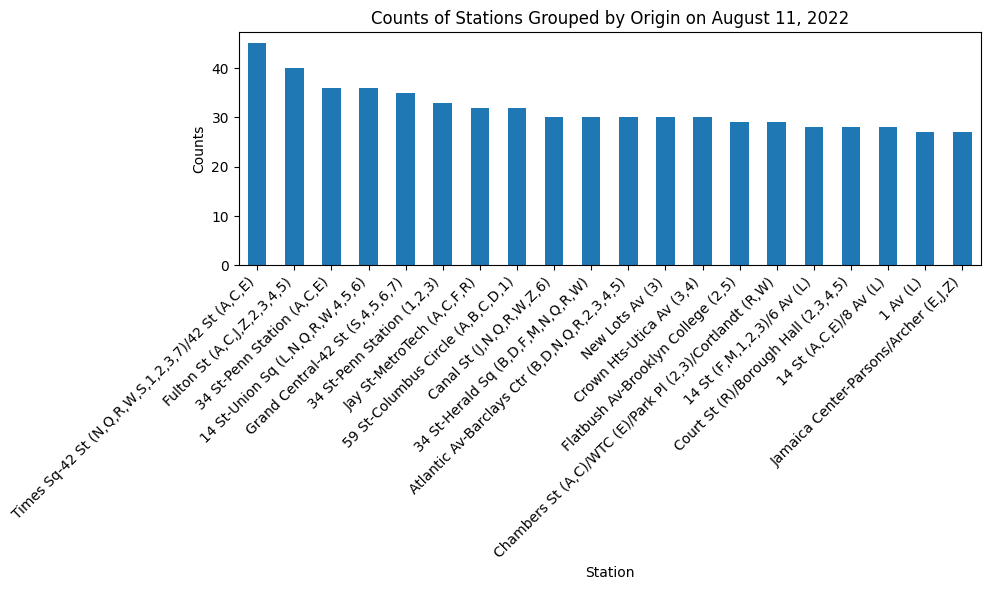

In [ ]:
plot_stations_counts(aug_8_high_hvi_low_income, 'August 8, 2022')
plot_stations_counts(aug_9_high_hvi_low_income, 'August 9, 2022')
plot_stations_counts(aug_11_high_hvi_low_income, 'August 11, 2022')

In [ ]:
aug_8_low_hvi_high_income = analyze_station_group(august_8_sampled, low_hvi_high_income, group_by_origin=True, limit=20)
aug_9_low_hvi_high_income =  analyze_station_group(august_9_sampled, low_hvi_high_income, group_by_origin=True, limit=20)
aug_11_low_hvi_high_income =  analyze_station_group(august_11_sampled, low_hvi_high_income, group_by_origin=True, limit=20)

In [ ]:
aug_8_low_hvi_low_income = analyze_station_group(august_8_sampled, low_hvi_low_income, group_by_origin=True, limit=20)
aug_9_low_hvi_low_income =  analyze_station_group(august_9_sampled, low_hvi_low_income, group_by_origin=True, limit=20)
aug_11_low_hvi_low_income =  analyze_station_group(august_11_sampled, low_hvi_low_income, group_by_origin=True, limit=20)

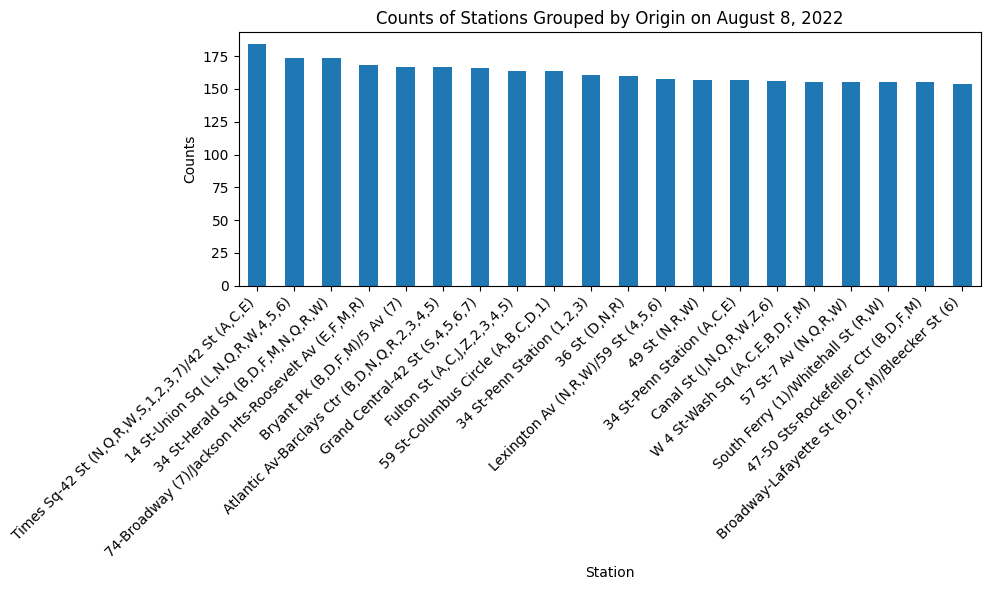

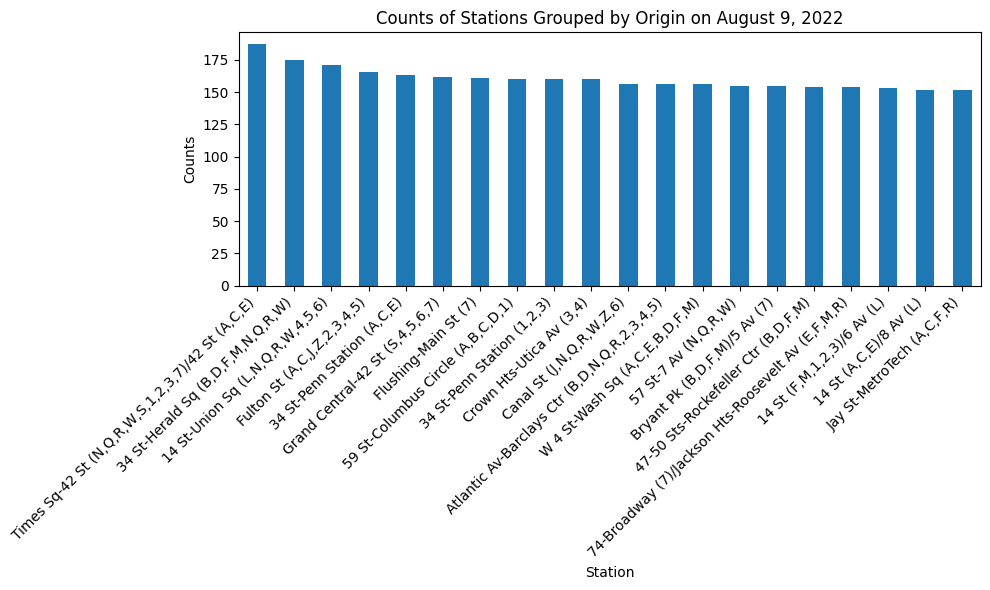

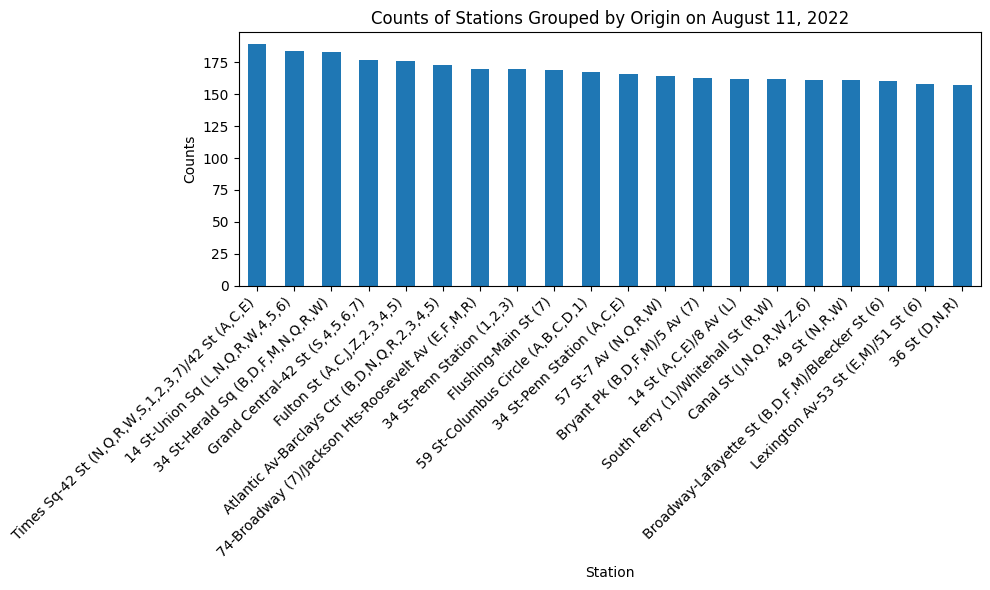

In [ ]:
plot_stations_counts(aug_8_low_hvi_high_income, 'August 8, 2022')
plot_stations_counts(aug_9_low_hvi_high_income, 'August 9, 2022')
plot_stations_counts(aug_11_low_hvi_high_income, 'August 11, 2022')

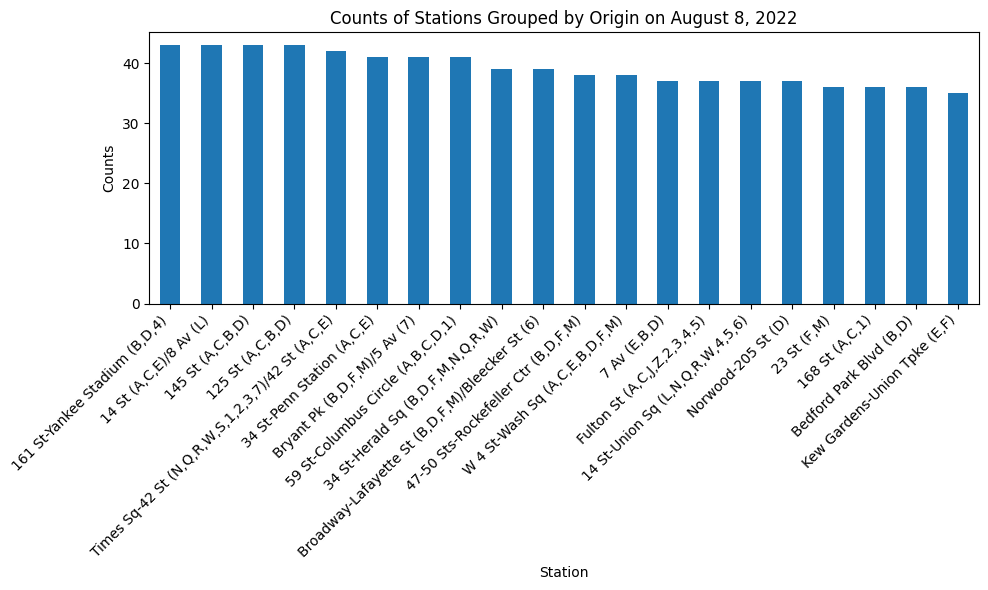

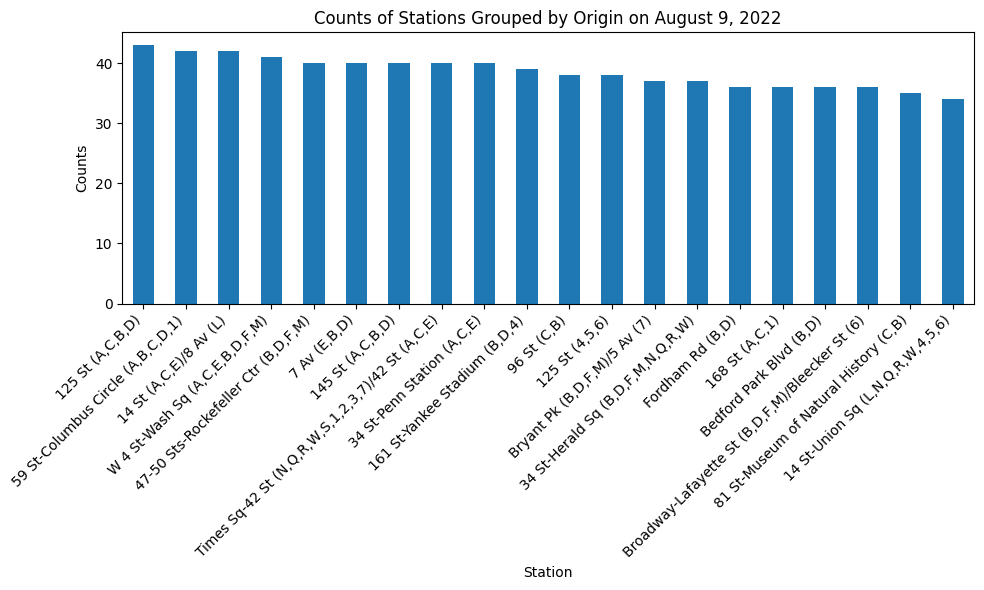

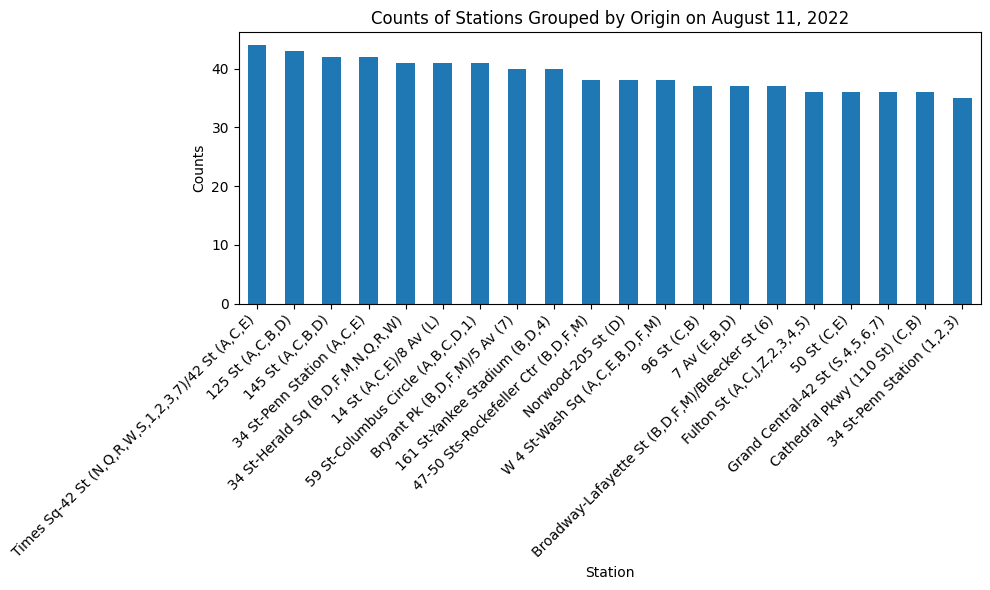

In [ ]:
plot_stations_counts(aug_8_low_hvi_low_income, 'August 8, 2022')
plot_stations_counts(aug_9_low_hvi_low_income, 'August 9, 2022')
plot_stations_counts(aug_11_low_hvi_low_income, 'August 11, 2022')

In [ ]:
combined_ridership_data = pd.concat([august_8_sampled, august_9_sampled, august_11_sampled], axis=0)

In [ ]:
combined_ridership_data['timestamp'] = pd.to_datetime(combined_ridership_data['timestamp'], errors='coerce')
combined_ridership_data['timestamp'] = combined_ridership_data['timestamp'].dt.round('H')

<ipython-input-100-32485abe5e50>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  combined_ridership_data['timestamp'] = combined_ridership_data['timestamp'].dt.round('H')


In [ ]:
august_8_sampled['timestamp'] = pd.to_datetime(august_8_sampled['timestamp'], errors='coerce')
august_9_sampled['timestamp'] = pd.to_datetime(august_9_sampled['timestamp'], errors='coerce')
august_11_sampled['timestamp'] = pd.to_datetime(august_11_sampled['timestamp'], errors='coerce')

# Now round the timestamps to the nearest hour
august_8_sampled['timestamp'] = august_8_sampled['timestamp'].dt.round('H')
august_9_sampled['timestamp'] = august_9_sampled['timestamp'].dt.round('H')
august_11_sampled['timestamp'] = august_11_sampled['timestamp'].dt.round('H')


<ipython-input-101-51afde3c0402>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  august_8_sampled['timestamp'] = august_8_sampled['timestamp'].dt.round('H')
<ipython-input-101-51afde3c0402>:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  august_9_sampled['timestamp'] = august_9_sampled['timestamp'].dt.round('H')
<ipython-input-101-51afde3c0402>:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  august_11_sampled['timestamp'] = august_11_sampled['timestamp'].dt.round('H')


# HVI/Income Clustering and Regression Model

In [ ]:

# Convert timestamps to datetime format and round to the nearest hour
combined_ridership_data['timestamp'] = pd.to_datetime(combined_ridership_data['timestamp'], errors='coerce').dt.round('H')

# Merge with weather data
merged_august_data = pd.merge(combined_ridership_data, nyc_hourly_temperatures, left_on='timestamp', right_on='time', how='inner')

# Perform cluster-specific regression
clusters = {
    "High HVI/High Income": ['7 Av', 'Beach 116 St', 'Mott'],
    "High HVI/Low Income": ['Tremont Av', 'Euclid Av', 'Sutphin Blvd - Archer Av'],
    "Low HVI/High Income": ['79 St', '68 - Hunter College', '14 St'],
    "Low HVI/Low Income": ['Seneca Av', 'Marble Hill - 225 St', 'Fresh Pond Rd']
}

regression_results = {}

for cluster_name, stations in clusters.items():
    # Filter for cluster data
    cluster_data = merged_august_data[
        merged_august_data['origin_station_complex_name'].str.contains('|'.join(stations), case=False, na=False)
    ]

    if cluster_data.empty:
        print(f"Skipping {cluster_name} due to insufficient data")
        continue

    # Prepare data for regression
    regression_data = cluster_data[
        [
            'estimated_average_ridership',
            'temperature_2m (°F)',
            'apparent_temperature (°F)',
            'precipitation (mm)',
            'rain (mm)',
            'cloud_cover (%)',
            'wind_speed_10m (km/h)'
        ]
    ].dropna()

    X = regression_data.drop('estimated_average_ridership', axis=1)
    y = regression_data['estimated_average_ridership']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Store results
    regression_results[cluster_name] = {
        "R-squared": r2,
        "Mean Absolute Error": mae,
        "Mean Squared Error": mse,
        "Feature Importance": pd.DataFrame({
            'Feature': X.columns,
            'Coefficient': model.coef_
        }).sort_values(by='Coefficient', ascending=False)
    }

# Display results for each cluster
for cluster_name, results in regression_results.items():
    print(f"Results for {cluster_name}:")
    print(f"R-squared: {results['R-squared']}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']}")
    print(f"Mean Squared Error: {results['Mean Squared Error']}")
    print("\nFeature Importance:")
    print(results["Feature Importance"])
    print("\n")

<ipython-input-238-0056acad5fb6>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  combined_ridership_data['timestamp'] = pd.to_datetime(combined_ridership_data['timestamp'], errors='coerce').dt.round('H')


Results for High HVI/High Income:
R-squared: 0.008861189691294347
Mean Absolute Error: 2.1270183950486
Mean Squared Error: 23.464862973292163

Feature Importance:
                     Feature  Coefficient
0        temperature_2m (°F)     0.150493
2         precipitation (mm)     0.074565
3                  rain (mm)     0.074565
4            cloud_cover (%)    -0.005003
5      wind_speed_10m (km/h)    -0.071260
1  apparent_temperature (°F)    -0.102924


Results for High HVI/Low Income:
R-squared: 0.00572505130347889
Mean Absolute Error: 1.2343128961564906
Mean Squared Error: 6.557048385049404

Feature Importance:
                     Feature  Coefficient
1  apparent_temperature (°F)     0.016623
5      wind_speed_10m (km/h)     0.014359
4            cloud_cover (%)    -0.000351
2         precipitation (mm)    -0.018492
3                  rain (mm)    -0.018492
0        temperature_2m (°F)    -0.041564


Results for Low HVI/High Income:
R-squared: 0.016778797277520296
Mean Absolute Err

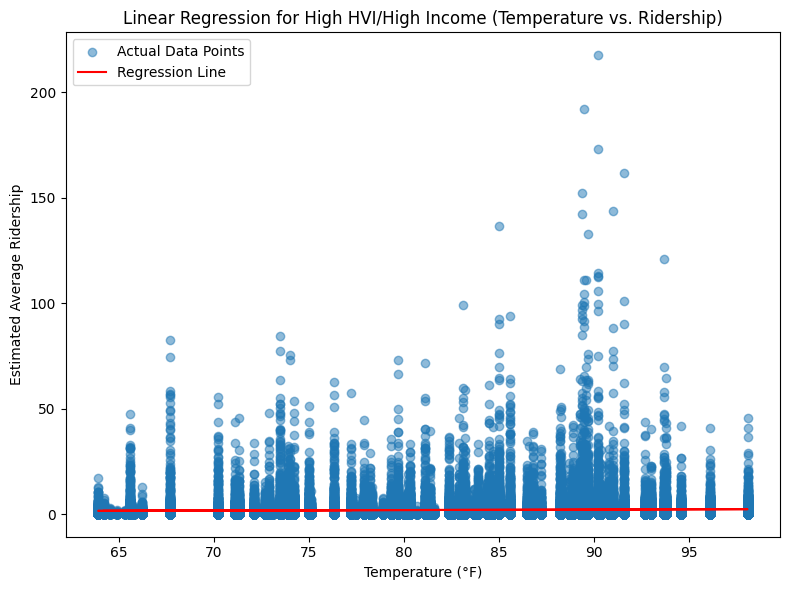

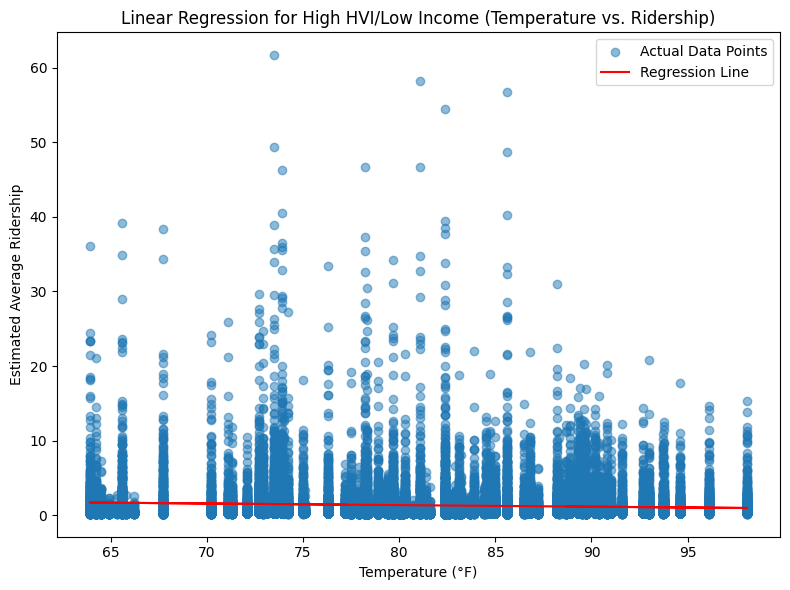

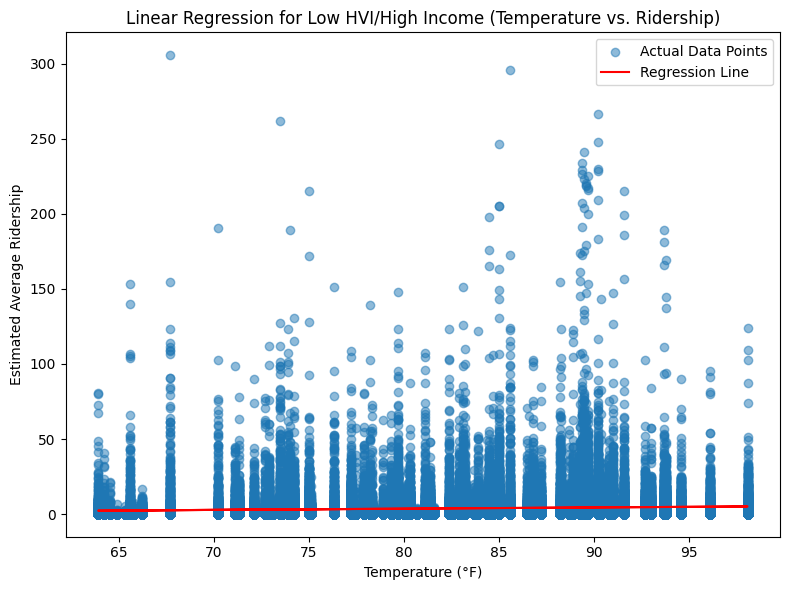

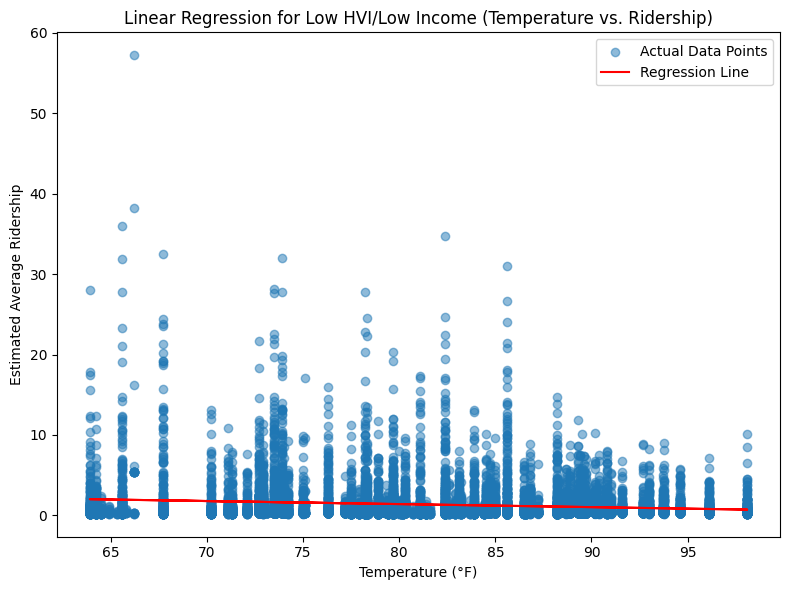

In [ ]:
# Visualize the linear regression model with line graphs and data points
for cluster_name, results in regression_results.items():
    # Filter for the cluster data
    cluster_data = merged_august_data[
        merged_august_data['origin_station_complex_name'].str.contains('|'.join(clusters[cluster_name]), case=False, na=False)
    ]

    if not cluster_data.empty:
        # Prepare data for regression
        regression_data = cluster_data[
            [
                'estimated_average_ridership',
                'temperature_2m (°F)',
                'apparent_temperature (°F)',
                'precipitation (mm)',
                'rain (mm)',
                'cloud_cover (%)',
                'wind_speed_10m (km/h)'
            ]
        ].dropna()

        X = regression_data.drop('estimated_average_ridership', axis=1)
        y = regression_data['estimated_average_ridership']

        # Create a simple regression with temperature as an example
        if 'temperature_2m (°F)' in X.columns:
            X_temp = X[['temperature_2m (°F)']]
            model = LinearRegression()
            model.fit(X_temp, y)
            y_pred = model.predict(X_temp)

            # Plot actual data points and the regression line
            plt.figure(figsize=(8, 6))
            plt.scatter(X_temp, y, alpha=0.5, label="Actual Data Points")
            plt.plot(X_temp, y_pred, color='red', label="Regression Line")
            plt.title(f"Linear Regression for {cluster_name} (Temperature vs. Ridership)")
            plt.xlabel("Temperature (°F)")
            plt.ylabel("Estimated Average Ridership")
            plt.legend()
            plt.tight_layout()
            plt.show()


In [ ]:

# Convert timestamps to datetime format and round to the nearest hour
combined_ridership_data['timestamp'] = pd.to_datetime(combined_ridership_data['timestamp'], errors='coerce').dt.round('H')

# Merge with weather data
merged_august_data = pd.merge(combined_ridership_data, nyc_hourly_temperatures, left_on='timestamp', right_on='time', how='inner')

# Perform cluster-specific regression for beaches
clusters = {
    "Coney Island and Brighton Beach": ['Coney Island - Stillwell Av', 'Neptune Av', 'Brighton Beach', 'W 8 St - NY Aquarium', 'Ocean Pkwy'],
    "Rockaway Beach": ['Beach 67 St', 'Beach 90 St', 'Beach 60 St', 'Rockaway Park-Beach 116 St', 'Beach 36 St (A)', 'Beach 25 St', 'Beach 105 St (A,S)', 'Beach 98 St (A,S)', 'Broad Channel'],
}

regression_results = {}

for cluster_name, stations in clusters.items():
    # Filter for cluster data
    cluster_data = merged_august_data[
        merged_august_data['origin_station_complex_name'].str.contains('|'.join(stations), case=False, na=False)
    ]

    if cluster_data.empty:
        print(f"Skipping {cluster_name} due to insufficient data")
        continue

    # Prepare data for regression
    regression_data = cluster_data[
        [
            'estimated_average_ridership',
            'temperature_2m (°F)',
            'apparent_temperature (°F)',
            'precipitation (mm)',
            'rain (mm)',
            'cloud_cover (%)',
            'wind_speed_10m (km/h)'
        ]
    ].dropna()

    X = regression_data.drop('estimated_average_ridership', axis=1)
    y = regression_data['estimated_average_ridership']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Store results
    regression_results[cluster_name] = {
        "R-squared": r2,
        "Mean Absolute Error": mae,
        "Mean Squared Error": mse,
        "Feature Importance": pd.DataFrame({
            'Feature': X.columns,
            'Coefficient': model.coef_
        }).sort_values(by='Coefficient', ascending=False)
    }

# Display results for each cluster
for cluster_name, results in regression_results.items():
    print(f"Results for {cluster_name}:")
    print(f"R-squared: {results['R-squared']}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']}")
    print(f"Mean Squared Error: {results['Mean Squared Error']}")
    print("\nFeature Importance:")
    print(results["Feature Importance"])
    print("\n")

NameError: name 'combined_ridership_data' is not defined

In [ ]:
filtered_cluster_data.head()

,year,month,day_of_week,hour_of_day,timestamp,origin_station_complex_id,origin_station_complex_name,origin_latitude,origin_longitude,destination_station_complex_id,...,origin_point,destination_point,weight,time,temperature_2m (°F),apparent_temperature (°F),precipitation (mm),rain (mm),cloud_cover (%),wind_speed_10m (km/h)
35,2022,9,Thursday,5,2022-09-08 05:00:00,209,Far Rockaway-Mott Av (A),40.603995,-73.755405,619,...,"{'type': 'Point', 'coordinates': [-73.755405, ...","{'type': 'Point', 'coordinates': [-73.995432, ...",4.139503e-07,2022-09-08 05:00:00,64.2,65.8,0.0,0.0,87.0,9.6
55,2022,8,Monday,11,2022-08-08 11:00:00,240,"7 Av (F,G)",40.666271,-73.980305,165,...,"{'type': 'Point', 'coordinates': [-73.980305, ...","{'type': 'Point', 'coordinates': [-73.998041, ...",4.139503e-07,2022-08-08 11:00:00,88.7,94.7,0.0,0.0,99.0,20.2
140,2022,8,Monday,15,2022-08-08 15:00:00,9,"57 St-7 Av (N,Q,R,W)",40.764664,-73.980658,457,...,"{'type': 'Point', 'coordinates': [-73.980658, ...","{'type': 'Point', 'coordinates': [-73.912549, ...",4.139503e-07,2022-08-08 15:00:00,93.8,97.9,0.0,0.0,99.0,16.7
217,2022,8,Monday,17,2022-08-08 17:00:00,240,"7 Av (F,G)",40.666271,-73.980305,42,...,"{'type': 'Point', 'coordinates': [-73.980305, ...","{'type': 'Point', 'coordinates': [-73.962246, ...",4.139503e-07,2022-08-08 17:00:00,91.6,95.1,0.0,0.0,53.0,17.3
233,2022,8,Monday,22,2022-08-08 22:00:00,9,"57 St-7 Av (N,Q,R,W)",40.764664,-73.980658,124,...,"{'type': 'Point', 'coordinates': [-73.980658, ...","{'type': 'Point', 'coordinates': [-73.93985, 4...",4.139503e-07,2022-08-08 22:00:00,84.4,87.8,0.0,0.0,39.0,19.7


In [ ]:
filtered_cluster_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23409 entries, 35 to 1450855
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   year                              23409 non-null  int64         
 1   month                             23409 non-null  int64         
 2   day_of_week                       23409 non-null  object        
 3   hour_of_day                       23409 non-null  int64         
 4   timestamp                         23409 non-null  datetime64[ns]
 5   origin_station_complex_id         23409 non-null  int64         
 6   origin_station_complex_name       23409 non-null  object        
 7   origin_latitude                   23409 non-null  float64       
 8   origin_longitude                  23409 non-null  float64       
 9   destination_station_complex_id    23409 non-null  int64         
 10  destination_station_complex_name  23409 non-null

In [ ]:
!pip install ace_tools

In [ ]:
for cluster_name, results in regression_results.items():
    tools.display_dataframe_to_user(
        name=f"Regression Results for {cluster_name}",
        dataframe=pd.DataFrame([{
            "R-squared": results["R-squared"],
            "Mean Absolute Error": results["Mean Absolute Error"],
            "Mean Squared Error": results["Mean Squared Error"]
        }])
    )
    tools.display_dataframe_to_user(
        name=f"Feature Importance for {cluster_name}",
        dataframe=results["Feature Importance"]
    )

In [ ]:
print(nyc_hourly_temperatures.dtypes)
print(august_8_sampled.dtypes)

time                          object
temperature_2m (°F)          float64
apparent_temperature (°F)    float64
precipitation (mm)           float64
rain (mm)                    float64
cloud_cover (%)              float64
wind_speed_10m (km/h)        float64
dtype: object
year                                         int64
month                                        int64
day_of_week                                 object
hour_of_day                                  int64
timestamp                           datetime64[ns]
origin_station_complex_id                    int64
origin_station_complex_name                 object
origin_latitude                            float64
origin_longitude                           float64
destination_station_complex_id               int64
destination_station_complex_name            object
destination_latitude                       float64
destination_longitude                      float64
estimated_average_ridership                float64
origin_point 

In [ ]:
nyc_hourly_temperatures.head()

,time,temperature_2m (°F),apparent_temperature (°F),precipitation (mm),rain (mm),cloud_cover (%),wind_speed_10m (km/h)
0,2020-01-01T00:00,37.0,28.1,0.0,0.0,2.0,18.4
1,2020-01-01T01:00,35.1,26.2,0.0,0.0,0.0,17.3
2,2020-01-01T02:00,34.3,25.4,0.0,0.0,0.0,17.3
3,2020-01-01T03:00,33.5,24.1,0.0,0.0,25.0,18.7
4,2020-01-01T04:00,33.0,23.6,0.0,0.0,77.0,18.0


In [ ]:
nyc_hourly_temperatures[['time']]

,time
0,2020-01-01T00:00
1,2020-01-01T01:00
2,2020-01-01T02:00
3,2020-01-01T03:00
4,2020-01-01T04:00
...,...
42499,2024-11-05T19:00
42500,2024-11-05T20:00
42501,2024-11-05T21:00
42502,2024-11-05T22:00


In [ ]:
august_8_sampled[['timestamp']]

,timestamp
2200800,2022-09-08T14:00:00.000
2122539,2022-09-08T13:00:00.000
589421,2022-08-08T12:00:00.000
1430985,2022-09-08T00:00:00.000
60929,2022-08-08T04:00:00.000
...,...
1256356,2022-08-08T20:00:00.000
1420551,2022-09-08T00:00:00.000
1089725,2022-08-08T18:00:00.000
334180,2022-08-08T08:00:00.000


In [ ]:
stations_to_group = ['79 St', '68 - Hunter College', '14 St']
station = august_8_sampled
aug_8_low_hvi_high_income = analyze_station_group(station, stations_to_group, group_by_origin=True)
aug_8_low_hvi_high_income.head()

,count
destination_station_complex_name,
"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",142
"74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,M,R)",139
"Grand Central-42 St (S,4,5,6,7)",137
"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",137
"59 St-Columbus Circle (A,B,C,D,1)",133


In [ ]:
stations_to_group = ['Tremont Av', 'Euclid Av', 'Sutphin Blvd - Archer Av']
station = august_8_sampled
aug_8_high_hvi_low_income = analyze_station_group(station, stations_to_group, group_by_origin=True)
aug_8_high_hvi_low_income.head()

,count
destination_station_complex_name,
"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",96
"Grand Central-42 St (S,4,5,6,7)",90
"125 St (4,5,6)",85
"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",85
"59 St-Columbus Circle (A,B,C,D,1)",82


In [ ]:
stations_to_group = ['Seneca Av','Marble Hill - 225 St', 'Fresh Pond Rd']
station = august_8_sampled
aug_8_low_hvi_low_income = analyze_station_group(station, stations_to_group, group_by_origin=True)
aug_8_low_hvi_low_income.head()

,count
destination_station_complex_name,
"14 St-Union Sq (L,N,Q,R,W,4,5,6)",45
"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",42
"Delancey St (F)/Essex St (J,M,Z)",42
"Bryant Pk (B,D,F,M)/5 Av (7)",40
"Fulton St (A,C,J,Z,2,3,4,5)",40


In [ ]:
# Parameters
OUTPUT_CSV = "filtered_rows.csv"  # Output file
START_ROW = 4500000  # Start row
END_ROW = 9340736  # End row
BATCH_SIZE = 10000  # Rows per API request
MAX_WORKERS = 5  # Number of parallel workers

# Fetch the data for the specified range and save to CSV
fetch_range_dataset(OUTPUT_CSV, START_ROW, END_ROW, limit=BATCH_SIZE, month=7, max_workers=MAX_WORKERS)
print(f"Data from rows {START_ROW} to {END_ROW} saved to {OUTPUT_CSV}.")


In [ ]:
filtered_rows = pd.read_csv('/content/drive/MyDrive/Cornell/INFO5430: Urban Data /INFO5430 Urban Data Final Project/Data/filteredrows.zip (Unzipped Files)/filtered_rows.csv')
filtered_rows.head()

,year,month,day_of_week,hour_of_day,timestamp,origin_station_complex_id,origin_station_complex_name,origin_latitude,origin_longitude,destination_station_complex_id,destination_station_complex_name,destination_latitude,destination_longitude,estimated_average_ridership,origin_point,destination_point
0,2022,7,Monday,1,2022-07-04T01:00:00.000,158,"86 St (C,B)",40.785868,-73.968916,605,"168 St (A,C,1)",40.840638,-73.939847,0.5000,"{'type': 'Point', 'coordinates': [-73.968916, ...","{'type': 'Point', 'coordinates': [-73.939847, ..."
1,2022,7,Monday,1,2022-07-04T01:00:00.000,611,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",40.755746,-73.987581,269,"Northern Blvd (M,R)",40.752885,-73.906006,0.8955,"{'type': 'Point', 'coordinates': [-73.987581, ...","{'type': 'Point', 'coordinates': [-73.906006, ..."
2,2022,7,Monday,1,2022-07-04T01:00:00.000,97,"Myrtle Av (M,J,Z)",40.697207,-73.935657,618,"14 St (A,C,E)/8 Av (L)",40.740335,-74.002134,0.2878,"{'type': 'Point', 'coordinates': [-73.935657, ...","{'type': 'Point', 'coordinates': [-74.002134, ..."
3,2022,7,Monday,1,2022-07-04T01:00:00.000,611,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",40.755746,-73.987581,84,85 St-Forest Pkwy (J),40.692435,-73.860010,0.5597,"{'type': 'Point', 'coordinates': [-73.987581, ...","{'type': 'Point', 'coordinates': [-73.86001, 4..."
4,2022,7,Monday,1,2022-07-04T01:00:00.000,423,"Allerton Av (2,5)",40.865462,-73.867352,433,"Jackson Av (2,5)",40.816490,-73.907807,0.3125,"{'type': 'Point', 'coordinates': [-73.867352, ...","{'type': 'Point', 'coordinates': [-73.907807, ..."


In [ ]:
august_8 = pd.read_csv('/content/filtered_rows_august_8.csv')
august_8.info()

FileNotFoundError: [Errno 2] No such file or directory: '/content/filtered_rows_august_8.csv'

In [ ]:
august_8[august_8['destination_station_complex_name'].str.contains("Far Rockaway") == True]

,year,month,day_of_week,hour_of_day,timestamp,origin_station_complex_id,origin_station_complex_name,origin_latitude,origin_longitude,destination_station_complex_id,destination_station_complex_name,destination_latitude,destination_longitude,estimated_average_ridership,origin_point,destination_point
80,2022,8,Monday,0,2022-08-08T00:00:00.000,628,"Fulton St (A,C,J,Z,2,3,4,5)",40.710089,-74.007838,209,Far Rockaway-Mott Av (A),40.603995,-73.755405,1.4792,"{'type': 'Point', 'coordinates': [-74.007838, ...","{'type': 'Point', 'coordinates': [-73.755405, ..."
371,2022,8,Monday,0,2022-08-08T00:00:00.000,198,Howard Beach-JFK Airport (A),40.660476,-73.830301,209,Far Rockaway-Mott Av (A),40.603995,-73.755405,2.1938,"{'type': 'Point', 'coordinates': [-73.830301, ...","{'type': 'Point', 'coordinates': [-73.755405, ..."
1588,2022,8,Monday,0,2022-08-08T00:00:00.000,31,25 St (R),40.660397,-73.998091,209,Far Rockaway-Mott Av (A),40.603995,-73.755405,0.2000,"{'type': 'Point', 'coordinates': [-73.998091, ...","{'type': 'Point', 'coordinates': [-73.755405, ..."
1991,2022,8,Monday,0,2022-08-08T00:00:00.000,318,"34 St-Penn Station (1,2,3)",40.750373,-73.991057,209,Far Rockaway-Mott Av (A),40.603995,-73.755405,0.2344,"{'type': 'Point', 'coordinates': [-73.991057, ...","{'type': 'Point', 'coordinates': [-73.755405, ..."
2112,2022,8,Monday,0,2022-08-08T00:00:00.000,125,Morgan Av (L),40.706152,-73.933147,209,Far Rockaway-Mott Av (A),40.603995,-73.755405,0.2000,"{'type': 'Point', 'coordinates': [-73.933147, ...","{'type': 'Point', 'coordinates': [-73.755405, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1415966,2022,8,Monday,23,2022-08-08T23:00:00.000,118,3 Av (L),40.732849,-73.986122,209,Far Rockaway-Mott Av (A),40.603995,-73.755405,0.2596,"{'type': 'Point', 'coordinates': [-73.986122, ...","{'type': 'Point', 'coordinates': [-73.755405, ..."
1416063,2022,8,Monday,23,2022-08-08T23:00:00.000,605,"168 St (A,C,1)",40.840638,-73.939847,209,Far Rockaway-Mott Av (A),40.603995,-73.755405,0.2272,"{'type': 'Point', 'coordinates': [-73.939847, ...","{'type': 'Point', 'coordinates': [-73.755405, ..."
1416306,2022,8,Monday,23,2022-08-08T23:00:00.000,151,"145 St (A,C,B,D)",40.824783,-73.944216,209,Far Rockaway-Mott Av (A),40.603995,-73.755405,0.2778,"{'type': 'Point', 'coordinates': [-73.944216, ...","{'type': 'Point', 'coordinates': [-73.755405, ..."
1416775,2022,8,Monday,23,2022-08-08T23:00:00.000,618,"14 St (A,C,E)/8 Av (L)",40.740335,-74.002134,209,Far Rockaway-Mott Av (A),40.603995,-73.755405,0.7134,"{'type': 'Point', 'coordinates': [-74.002134, ...","{'type': 'Point', 'coordinates': [-73.755405, ..."


In [ ]:
august_8[['destination_station_name']].

In [ ]:
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor



In [ ]:
# Define the base URL for the API
BASE_URL = "https://data.ny.gov/resource/nqnz-e9z9.json"

# Function to fetch a single batch
def fetch_batch(offset, limit=50000):
    """
    Fetches a batch of data from the API with a given offset and limit.
    """
    url = f"{BASE_URL}?$limit={limit}&$offset={offset}"
    try:
        response = requests.get(url, timeout=10)  # 10-second timeout
        response.raise_for_status()  # Raise error if request fails
        return pd.DataFrame(response.json())
    except Exception as e:
        print(f"Error fetching offset {offset}: {e}")
        return pd.DataFrame()  # Return empty DataFrame on error

# Function to fetch data in parallel
def fetch_data_parallel(total_rows, limit=50000, max_workers=5):
    """
    Fetches data in parallel from the API.
    Args:
        total_rows: Total number of rows to fetch.
        limit: Number of rows per batch.
        max_workers: Number of parallel threads.
    Returns:
        Combined DataFrame of all fetched data.
    """
    # Calculate offsets for each batch
    offsets = [i for i in range(0, total_rows, limit)]

    # Use ThreadPoolExecutor to fetch batches in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(fetch_batch, offsets, [limit] * len(offsets)))

    # Combine all batches into a single DataFrame
    combined_data = pd.concat(results, ignore_index=True)
    return combined_data

# Parameters
TOTAL_ROWS = 1000000  # Adjust this to match the approximate dataset size
BATCH_SIZE = 50000  # Number of rows per batch
MAX_WORKERS = 10  # Number of threads to use

# Fetch data
data = fetch_data_parallel(total_rows=TOTAL_ROWS, limit=BATCH_SIZE, max_workers=MAX_WORKERS)

# Save or inspect the data
# print(data.head())
data.to_csv("fetched_data.csv", index=False)


In [ ]:
data[['day_of_week']].value_counts()

,count
day_of_week,
Tuesday,394070
Sunday,250000
Monday,155930
Wednesday,150000
Thursday,50000


In [ ]:
import requests
import pandas as pd

# Base API URL
BASE_URL = "https://data.ny.gov/resource/nqnz-e9z9.json"

# Function to fetch data for a specific hour
def fetch_hour_data(day, month, hour, limit=5000):
    """
    Fetches data for a specific day, month, and hour of the day using the API.
    """
    query = f"{BASE_URL}?$where=day_of_week='{day}' AND month={month} AND hour_of_day={hour}&$limit={limit}"
    try:
        response = requests.get(query, timeout=10)  # 10-second timeout
        response.raise_for_status()  # Raise error if request fails
        data = response.json()  # Parse JSON response
        return pd.DataFrame(data)  # Convert to Pandas DataFrame
    except Exception as e:
        print(f"Error fetching data for hour {hour}: {e}")
        return pd.DataFrame()  # Return empty DataFrame on error

# Fetch data for each hour and store it
def fetch_proportional_data(day, month, limit_per_hour=5000):
    """
    Fetches data for each hour of the day and combines them into a proportional dataset.
    """
    all_data = []
    for hour in range(24):  # Loop through all 24 hours
        hour_data = fetch_hour_data(day, month, hour, limit=limit_per_hour)
        all_data.append(hour_data)  # Append the DataFrame to the list

    # Combine all hourly data into one DataFrame
    combined_data = pd.concat(all_data, ignore_index=True)
    return combined_data

# Fetch proportional data for Sunday in July
proportional_data = fetch_proportional_data(day='Sunday', month=7, limit_per_hour=5000)

# Check the result and save
print(proportional_data['hour_of_day'].value_counts(normalize=True))  # Check proportions
proportional_data.to_csv("sunday_proportional_data.csv", index=False)


hour_of_day
0     0.041667
1     0.041667
22    0.041667
21    0.041667
20    0.041667
19    0.041667
18    0.041667
17    0.041667
16    0.041667
15    0.041667
14    0.041667
13    0.041667
12    0.041667
11    0.041667
10    0.041667
9     0.041667
8     0.041667
7     0.041667
6     0.041667
5     0.041667
4     0.041667
3     0.041667
2     0.041667
23    0.041667
Name: proportion, dtype: float64


In [ ]:
# Function to fetch data for weekends
def fetch_weekend_data(limit=128297):
    """
    Fetches data for Saturday and Sunday using the API.
    """
    # Construct the API query with $where clause for filtering
    query = f"{BASE_URL}?$where=day_of_week='Sunday'&month=7&$limit={limit}"
    try:
        response = requests.get(query, timeout=10)  # 10-second timeout
        response.raise_for_status()  # Raise error if request fails
        data = response.json()  # Parse JSON response
        return pd.DataFrame(data)  # Convert to Pandas DataFrame
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()  # Return empty DataFrame on error

# Fetch 10,000 rows of weekend data
sunday_data = fetch_weekend_data()

# Check and save the data
print(sunday_data.head())
# sunday_data.to_csv("sunday_data.csv", index=False)

   year month day_of_week hour_of_day                timestamp  \
0  2022     7      Sunday           1  2022-07-10T01:00:00.000   
1  2022     7      Sunday           1  2022-07-10T01:00:00.000   
2  2022     7      Sunday           1  2022-07-10T01:00:00.000   
3  2022     7      Sunday           1  2022-07-10T01:00:00.000   
4  2022     7      Sunday           1  2022-07-10T01:00:00.000   

  origin_station_complex_id       origin_station_complex_name origin_latitude  \
0                       434                 3 Av-149 St (2,5)       40.816109   
1                        16                    8 St-NYU (R,W)       40.730328   
2                       625  Delancey St (F)/Essex St (J,M,Z)       40.718463   
3                       107                    Broad St (J,Z)       40.706476   
4                       158                       86 St (C,B)       40.785868   

  origin_longitude destination_station_complex_id  \
0       -73.917757                            392   
1       -7

In [ ]:
from sklearn.model_selection import train_test_split

# Stratified sampling
_, stratified_sample = train_test_split(sunday_data, test_size=0.1, stratify=data['hour_of_day'], random_state=42)

# Check the distribution in the stratified sample
print(stratified_sample['hour_of_day'].value_counts(normalize=True))

ValueError: Found input variables with inconsistent numbers of samples: [128297, 1000000]

In [ ]:
# Function to fetch data for weekends
def fetch_weekend_data(limit=163583):
    """
    Fetches data for Saturday and Sunday using the API.
    """
    # Construct the API query with $where clause for filtering
    query = f"{BASE_URL}?$where=day_of_week='Monday'&month=7&$limit={limit}"
    try:
        response = requests.get(query, timeout=10)  # 10-second timeout
        response.raise_for_status()  # Raise error if request fails
        data = response.json()  # Parse JSON response
        return pd.DataFrame(data)  # Convert to Pandas DataFrame
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()  # Return empty DataFrame on error

# Fetch 10,000 rows of weekend data
monday_data = fetch_weekend_data()

# Check and save the data
print(monday_data.head())
# sunday_data.to_csv("sunday_data.csv", index=False)

In [ ]:
monday_data[['origin_station_complex_name']].value_counts()

NameError: name 'monday_data' is not defined

In [ ]:
# Function to fetch data for weekends
def fetch_weekend_data(limit=167314):
    """
    Fetches data for Saturday and Sunday using the API.
    """
    # Construct the API query with $where clause for filtering
    query = f"{BASE_URL}?$where=day_of_week='Tuesday'&month=7&$limit={limit}"
    try:
        response = requests.get(query, timeout=10)  # 10-second timeout
        response.raise_for_status()  # Raise error if request fails
        data = response.json()  # Parse JSON response
        return pd.DataFrame(data)  # Convert to Pandas DataFrame
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()  # Return empty DataFrame on error

# Fetch 10,000 rows of weekend data
tuesday_data = fetch_weekend_data()

# Check and save the data
print(tuesday_data.head())
# sunday_data.to_csv("sunday_data.csv", index=False)

In [ ]:
# Function to fetch data for weekends
def fetch_weekend_data(limit=169831):
    """
    Fetches data for Saturday and Sunday using the API.
    """
    # Construct the API query with $where clause for filtering
    query = f"{BASE_URL}?$where=day_of_week='Wednesday'&month=7&$limit={limit}"
    try:
        response = requests.get(query, timeout=10)  # 10-second timeout
        response.raise_for_status()  # Raise error if request fails
        data = response.json()  # Parse JSON response
        return pd.DataFrame(data)  # Convert to Pandas DataFrame
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()  # Return empty DataFrame on error

# Fetch 10,000 rows of weekend data
wednesday_data = fetch_weekend_data()

# Check and save the data
print(wednesday_data.head())
# sunday_data.to_csv("sunday_data.csv", index=False)

In [ ]:
# Function to fetch data for weekends
def fetch_weekend_data(limit=171457):
    """
    Fetches data for Saturday and Sunday using the API.
    """
    # Construct the API query with $where clause for filtering
    query = f"{BASE_URL}?$where=day_of_week='Thursday'&month=7&$limit={limit}"
    try:
        response = requests.get(query, timeout=10)  # 10-second timeout
        response.raise_for_status()  # Raise error if request fails
        data = response.json()  # Parse JSON response
        return pd.DataFrame(data)  # Convert to Pandas DataFrame
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()  # Return empty DataFrame on error

# Fetch 10,000 rows of weekend data
thursday_data = fetch_weekend_data()

# Check and save the data
print(thursday_data.head())
# sunday_data.to_csv("sunday_data.csv", index=False)

In [ ]:
# Function to fetch data for weekends
def fetch_weekend_data(limit=174613):
    """
    Fetches data for Saturday and Sunday using the API.
    """
    # Construct the API query with $where clause for filtering
    query = f"{BASE_URL}?$where=day_of_week='Friday'&month=7&$limit={limit}"
    try:
        response = requests.get(query, timeout=10)  # 10-second timeout
        response.raise_for_status()  # Raise error if request fails
        data = response.json()  # Parse JSON response
        return pd.DataFrame(data)  # Convert to Pandas DataFrame
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()  # Return empty DataFrame on error

# Fetch 10,000 rows of weekend data
friday_data = fetch_weekend_data()

# Check and save the data
print(friday_data.head())
# sunday_data.to_csv("sunday_data.csv", index=False)

In [ ]:
# Function to fetch data for weekends
def fetch_weekend_data(limit=144116):
    """
    Fetches data for Saturday and Sunday using the API.
    """
    # Construct the API query with $where clause for filtering
    query = f"{BASE_URL}?$where=day_of_week='Saturday'&month=7&$limit={limit}"
    try:
        response = requests.get(query, timeout=10)  # 10-second timeout
        response.raise_for_status()  # Raise error if request fails
        data = response.json()  # Parse JSON response
        return pd.DataFrame(data)  # Convert to Pandas DataFrame
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()  # Return empty DataFrame on error

# Fetch 10,000 rows of weekend data
saturday_data = fetch_weekend_data()

# Check and save the data
print(saturday_data.head())
# sunday_data.to_csv("sunday_data.csv", index=False)

In [ ]:
origin_destination_data = pd.concat([sunday_data, monday_data, tuesday_data, wednesday_data, thursday_data, friday_data, saturday_data])

In [ ]:
origin_destination_data[['day_of_week']].value_counts()

In [ ]:
origin_destination_data[['month']].value_counts()

# September 2023 O/D Data and Heatwaves

In [ ]:
sept2023_heatwave = pd.read_csv('/content/drive/MyDrive/INFO5430 Urban Data Final Project/Data/2023_sept4-5_MTA_Subway_Origin-Destination_Ridership_Estimate__2023.csv')

In [ ]:
sept2023_non_heatwave = pd.read_csv('/content/drive/MyDrive/INFO5430 Urban Data Final Project/Data/2023_sept7-8_MTA_Subway_Origin-Destination_Ridership_Estimate__2023.csv')

In [ ]:
sept2023_heatwave.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2780312 entries, 0 to 2780311
Data columns (total 16 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   Year                              int64  
 1   Month                             int64  
 2   Day of Week                       object 
 3   Hour of Day                       int64  
 4   Timestamp                         object 
 5   Origin Station Complex ID         int64  
 6   Origin Station Complex Name       object 
 7   Origin Latitude                   float64
 8   Origin Longitude                  float64
 9   Destination Station Complex ID    int64  
 10  Destination Station Complex Name  object 
 11  Destination Latitude              float64
 12  Destination Longitude             float64
 13  Estimated Average Ridership       float64
 14  Origin Point                      object 
 15  Destination Point                 object 
dtypes: float64(5), int64(5), object(6)
m

In [ ]:
sept2023_heatwave['Day of Week'].unique()

array(['Monday', 'Tuesday'], dtype=object)

In [ ]:
sept2023_non_heatwave['Day of Week'].unique()

array(['Friday', 'Thursday'], dtype=object)

In [ ]:
# Splitting heatwave vs. control datasets by day
sept4heatwave = sept2023_heatwave[sept2023_heatwave['Day of Week'] == 'Monday']
sept5heatwave = sept2023_heatwave[sept2023_heatwave['Day of Week'] == 'Tuesday']
sept7control = sept2023_non_heatwave[sept2023_non_heatwave['Day of Week'] == 'Thursday']
sept8control = sept2023_non_heatwave[sept2023_non_heatwave['Day of Week'] == 'Friday']

In [ ]:
# Random sampling of heatwave vs. control dates
sept4heatwave_sampled = sept4heatwave.sample(frac=0.1, random_state=42) # 10% sample, random_state for reproducibility
sept5heatwave_sampled = sept5heatwave.sample(frac=0.1, random_state=42)
sept7control_sampled = sept7control.sample(frac=0.1, random_state=42)
sept8control_sampled = sept8control.sample(frac=0.1, random_state=42)

In [ ]:
sept8control_sampled.columns

Index(['Year', 'Month', 'Day of Week', 'Hour of Day', 'Timestamp',
       'Origin Station Complex ID', 'Origin Station Complex Name',
       'Origin Latitude', 'Origin Longitude', 'Destination Station Complex ID',
       'Destination Station Complex Name', 'Destination Latitude',
       'Destination Longitude', 'Estimated Average Ridership', 'Origin Point',
       'Destination Point'],
      dtype='object')

## Cluster Analysis for Sept Heatwaves

In [ ]:
from scipy.stats import ttest_ind

# Combine heatwave data
heatwave_data = pd.concat([sept4heatwave_sampled, sept5heatwave_sampled])

# Combine control data
control_data = pd.concat([sept7control_sampled, sept8control_sampled])

# Perform the t-test
t_stat, p_value = ttest_ind(
    heatwave_data['Estimated Average Ridership'],
    control_data['Estimated Average Ridership'],
    equal_var=False  # Welch's t-test (handles unequal variances)
)

# Print results
print("Two-Sample T-Test Results:")
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

# Interpret the p-value
if p_value < 0.05:
    print("The difference in ridership between heat wave and control days is statistically significant.")
else:
    print("No statistically significant difference in ridership between heat wave and control days.")

Two-Sample T-Test Results:
T-Statistic: 0.7713794753599413
P-Value: 0.4404823524850925
No statistically significant difference in ridership between heat wave and control days.


## Beach Analysis

In [ ]:
heatwave_data.columns

Index(['Year', 'Month', 'Day of Week', 'Hour of Day', 'Timestamp',
       'Origin Station Complex ID', 'Origin Station Complex Name',
       'Origin Latitude', 'Origin Longitude', 'Destination Station Complex ID',
       'Destination Station Complex Name', 'Destination Latitude',
       'Destination Longitude', 'Estimated Average Ridership', 'Origin Point',
       'Destination Point'],
      dtype='object')

In [ ]:
# Define the list of Beach MTA Stations
beach_stations = ['Aquarium', 'Coney Island', 'Neptune', 'Bay 50 St', 'Ocean Pkwy', 'Beach']

# Filter the dataframe for rows where 'destination_station_complex_name' contains any of the strings in beach_stations
sept23_heatwave_beaches = heatwave_data[
    heatwave_data['Destination Station Complex Name'].str.contains('|'.join(beach_stations), case=False, na=False)
]

# Display the filtered dataframe
sept23_heatwave_beaches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5242 entries, 382098 to 2210540
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Year                              5242 non-null   int64  
 1   Month                             5242 non-null   int64  
 2   Day of Week                       5242 non-null   object 
 3   Hour of Day                       5242 non-null   int64  
 4   Timestamp                         5242 non-null   object 
 5   Origin Station Complex ID         5242 non-null   int64  
 6   Origin Station Complex Name       5242 non-null   object 
 7   Origin Latitude                   5242 non-null   float64
 8   Origin Longitude                  5242 non-null   float64
 9   Destination Station Complex ID    5242 non-null   int64  
 10  Destination Station Complex Name  5242 non-null   object 
 11  Destination Latitude              5242 non-null   float64
 12  Des

In [ ]:
# Filter the dataframe for rows where 'destination_station_complex_name' contains any of the strings in beach_stations
sept23_control_beaches = control_data[
    control_data['Destination Station Complex Name'].str.contains('|'.join(beach_stations), case=False, na=False)
]

# Display the filtered dataframe
sept23_control_beaches.head()

,Year,Month,Day of Week,Hour of Day,Timestamp,Origin Station Complex ID,Origin Station Complex Name,Origin Latitude,Origin Longitude,Destination Station Complex ID,Destination Station Complex Name,Destination Latitude,Destination Longitude,Estimated Average Ridership,Origin Point,Destination Point
2675580,2023,9,Thursday,8,09/07/2023 08:00:00 AM,175,"Hoyt-Schermerhorn Sts (A,C,G)",40.688484,-73.985001,200,"Beach 90 St (A,S)",40.588034,-73.813641,0.5788,POINT (-73.985001 40.688484),POINT (-73.813641 40.588034)
2865959,2023,9,Thursday,6,09/07/2023 06:00:00 AM,145,190 St (A),40.859022,-73.934180,58,"Coney Island-Stillwell Av (D,F,N,Q)",40.577422,-73.981233,0.5632,POINT (-73.93418 40.859022),POINT (-73.981233 40.577422)
2653009,2023,9,Thursday,9,09/07/2023 09:00:00 AM,314,66 St-Lincoln Center (1),40.773440,-73.982209,57,"W 8 St-NY Aquarium (F,Q)",40.576127,-73.975939,0.9293,POINT (-73.982209 40.77344),POINT (-73.975939 40.576127)
2343865,2023,9,Thursday,13,09/07/2023 01:00:00 PM,236,"Bergen St (F,G)",40.686145,-73.990862,200,"Beach 90 St (A,S)",40.588034,-73.813641,0.9062,POINT (-73.990862 40.686145),POINT (-73.813641 40.588034)
2626486,2023,9,Thursday,9,09/07/2023 09:00:00 AM,471,34 St-Hudson Yards (7),40.755882,-74.001910,58,"Coney Island-Stillwell Av (D,F,N,Q)",40.577422,-73.981233,0.9075,POINT (-74.00191 40.755882),POINT (-73.981233 40.577422)


In [ ]:
# Perform the t-test
t_stat, p_value = ttest_ind(
    sept23_heatwave_beaches['Estimated Average Ridership'],
    sept23_control_beaches['Estimated Average Ridership'],
    equal_var=False  # Welch's t-test (handles unequal variances)
)

# Print results
print("Two-Sample T-Test Results for Beach Stations:")
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("The difference in ridership between heat wave and control days for beach stations is statistically significant.")
else:
    print("No statistically significant difference in ridership between heat wave and control days for beach stations.")

Two-Sample T-Test Results for Beach Stations:
T-Statistic: -0.4382230960734601
P-Value: 0.6612333438989622
No statistically significant difference in ridership between heat wave and control days for beach stations.


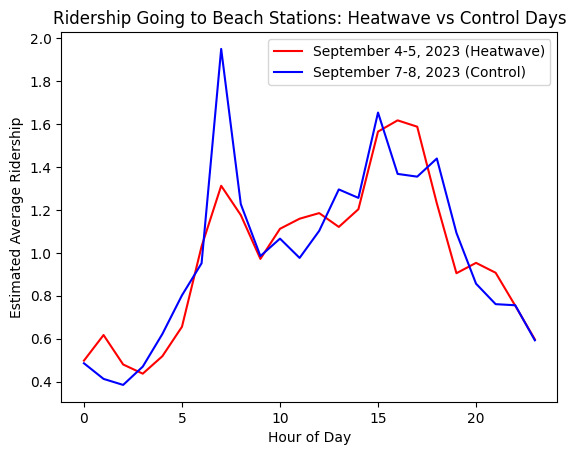

In [ ]:
# Ridership trends over time
sept23_beaches_trend = sept23_heatwave_beaches.groupby('Hour of Day')['Estimated Average Ridership'].mean()
sept23_control_beaches_trend = sept23_control_beaches.groupby('Hour of Day')['Estimated Average Ridership'].mean()

# Plot ridership trends
plt.plot(sept23_beaches_trend.index, sept23_beaches_trend, label='September 4-5, 2023 (Heatwave)', color='red')
plt.plot(sept23_control_beaches_trend.index, sept23_control_beaches_trend, label='September 7-8, 2023 (Control)', color='blue')
plt.title('Ridership to Beach Stations: Heatwave vs Control Days')
plt.xlabel('Hour of Day')
plt.ylabel('Estimated Average Ridership')
plt.legend()
plt.show()